<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v13: Extending all callbacks for value stats, magnitude stats, and activity stats, plus a new HistoryStats callback
I've since realised that:
a) I need to collect magnitude stats in order to produce sensible model-wide plots, and
b) I need to collect activity stats across all data types (layer outputs, layer backprop gradients, variables, variable gradients)

So here I've proving out changes to improve code re-use and standardise how that's all collected. Hopefully also to do it in a somewhat more efficient way.

Timing - simple regression model, CPU, collecting stats per-step:
* 36ms/epoch - baseline
* 220ms/epoch - single callback, value stats only (high variance)
* 140ms/epoch - single callback, activity stats only
* 280ms/epoch - single callback, value + activity stats

In [2]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout 6029c09
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at eefe488 Input structure warnings also fixed now
Already up to date.


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [3]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [4]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup


train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


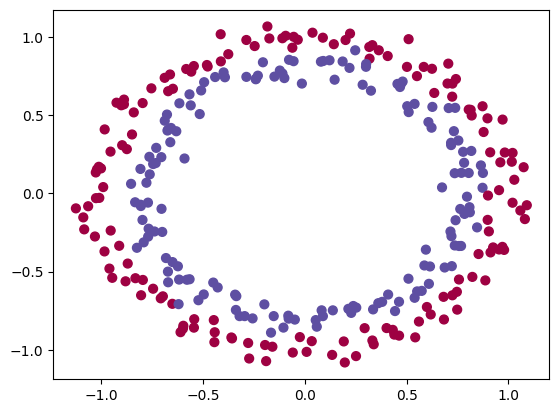

In [5]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Data Collection
Run a training sequence while collecting full stats.

In [71]:
reload(tot)
tf.config.run_functions_eagerly(False)

variables = tot.VariableHistoryCallback(per_step=True)
gradients = tot.GradientHistoryCallback(per_step=True)
outputs = tot.LayerOutputHistoryCallback(per_step=True)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tot.HistoryStats(per_step=True)])

Epoch     1 - 11.20s/epoch: accuracy: 0.5133  binary_crossentropy: 0.7414  loss: 0.7414  mse: 0.2672  
Epoch     2 - 532.13ms/epoch: accuracy: 0.5533  binary_crossentropy: 0.7337  loss: 0.7337  mse: 0.2600  
Epoch     3 - 519.85ms/epoch: accuracy: 0.5667  binary_crossentropy: 0.6792  loss: 0.6792  mse: 0.2415  
Epoch     4 - 537.98ms/epoch: accuracy: 0.5700  binary_crossentropy: 0.6539  loss: 0.6539  mse: 0.2316  
Epoch     5 - 622.88ms/epoch: accuracy: 0.6000  binary_crossentropy: 0.6799  loss: 0.6799  mse: 0.2373  
Epoch     6 - 531.75ms/epoch: accuracy: 0.6467  binary_crossentropy: 0.6233  loss: 0.6233  mse: 0.2171  
Epoch     7 - 512.22ms/epoch: accuracy: 0.6933  binary_crossentropy: 0.5973  loss: 0.5973  mse: 0.2046  
Epoch     8 - 964.96ms/epoch: accuracy: 0.6700  binary_crossentropy: 0.6344  loss: 0.6344  mse: 0.2212  
Epoch     9 - 537.69ms/epoch: accuracy: 0.7100  binary_crossentropy: 0.5560  loss: 0.5560  mse: 0.1893  
Epoch    10 - 603.21ms/epoch: accuracy: 0.6900  binary_cr

## Uber Plot

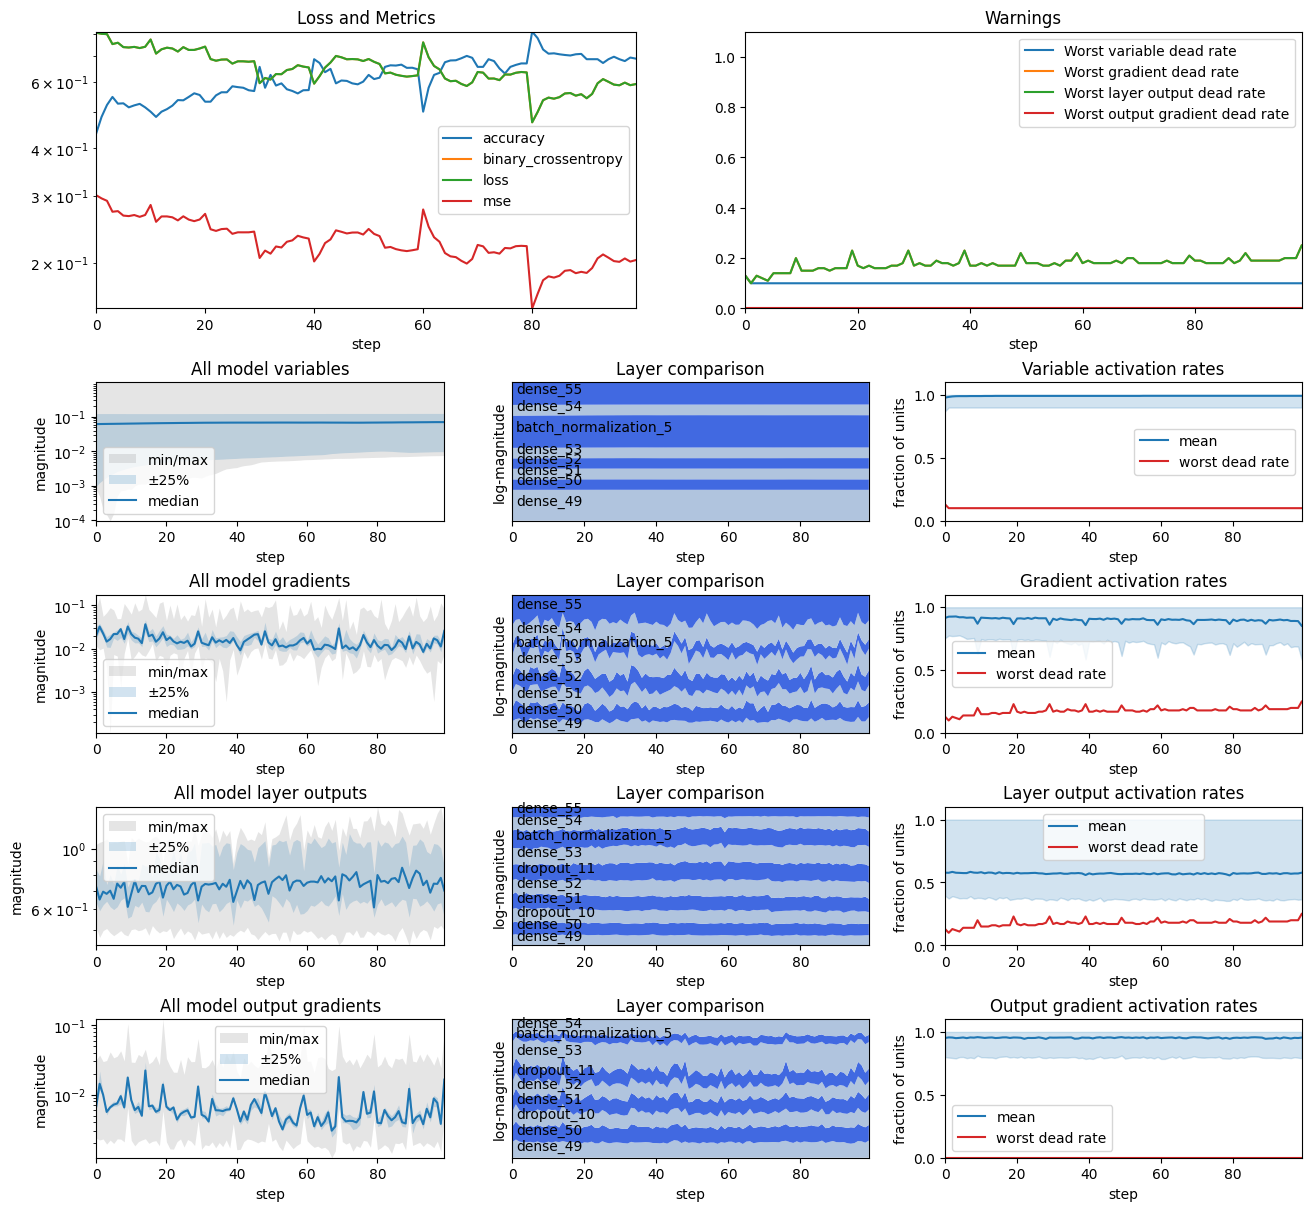

In [72]:
reload(tot)
tot.plot_history_overview([history, variables, gradients, outputs, output_gradients])

## History Plots

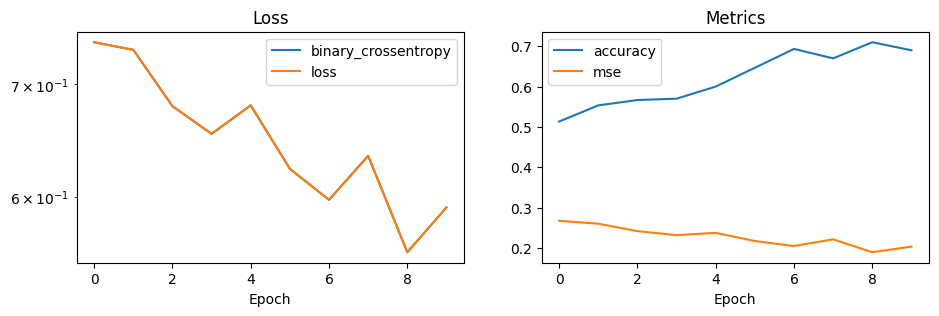

In [73]:
tot.plot_train_history(history, show_loss_percentiles=False, show_metric_percentiles=False)

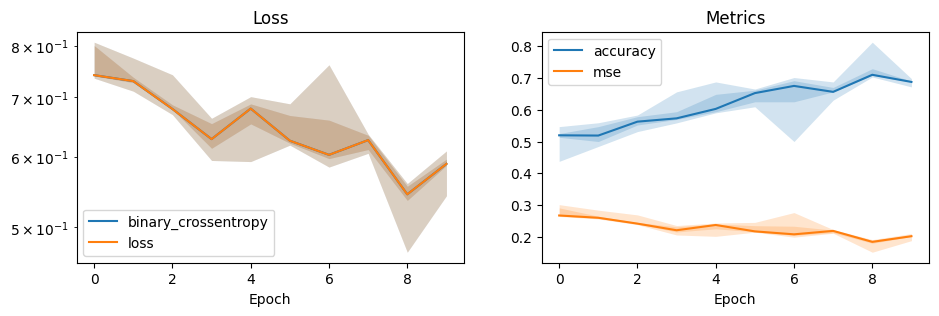

In [74]:
tot.plot_train_history(history)

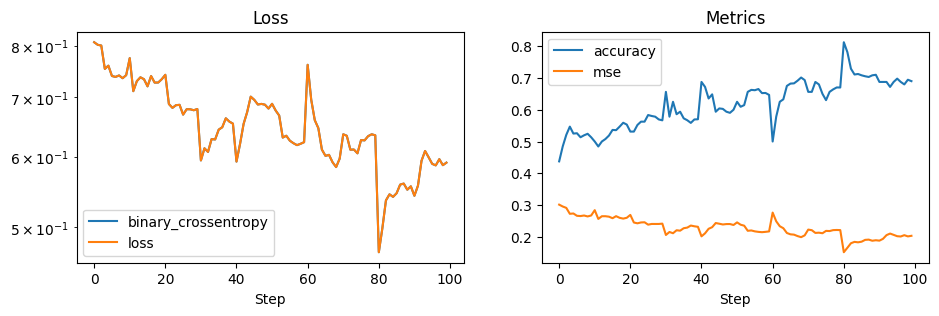

In [75]:
tot.plot_train_history(history, per_step=True)

## Individual Callback Plots


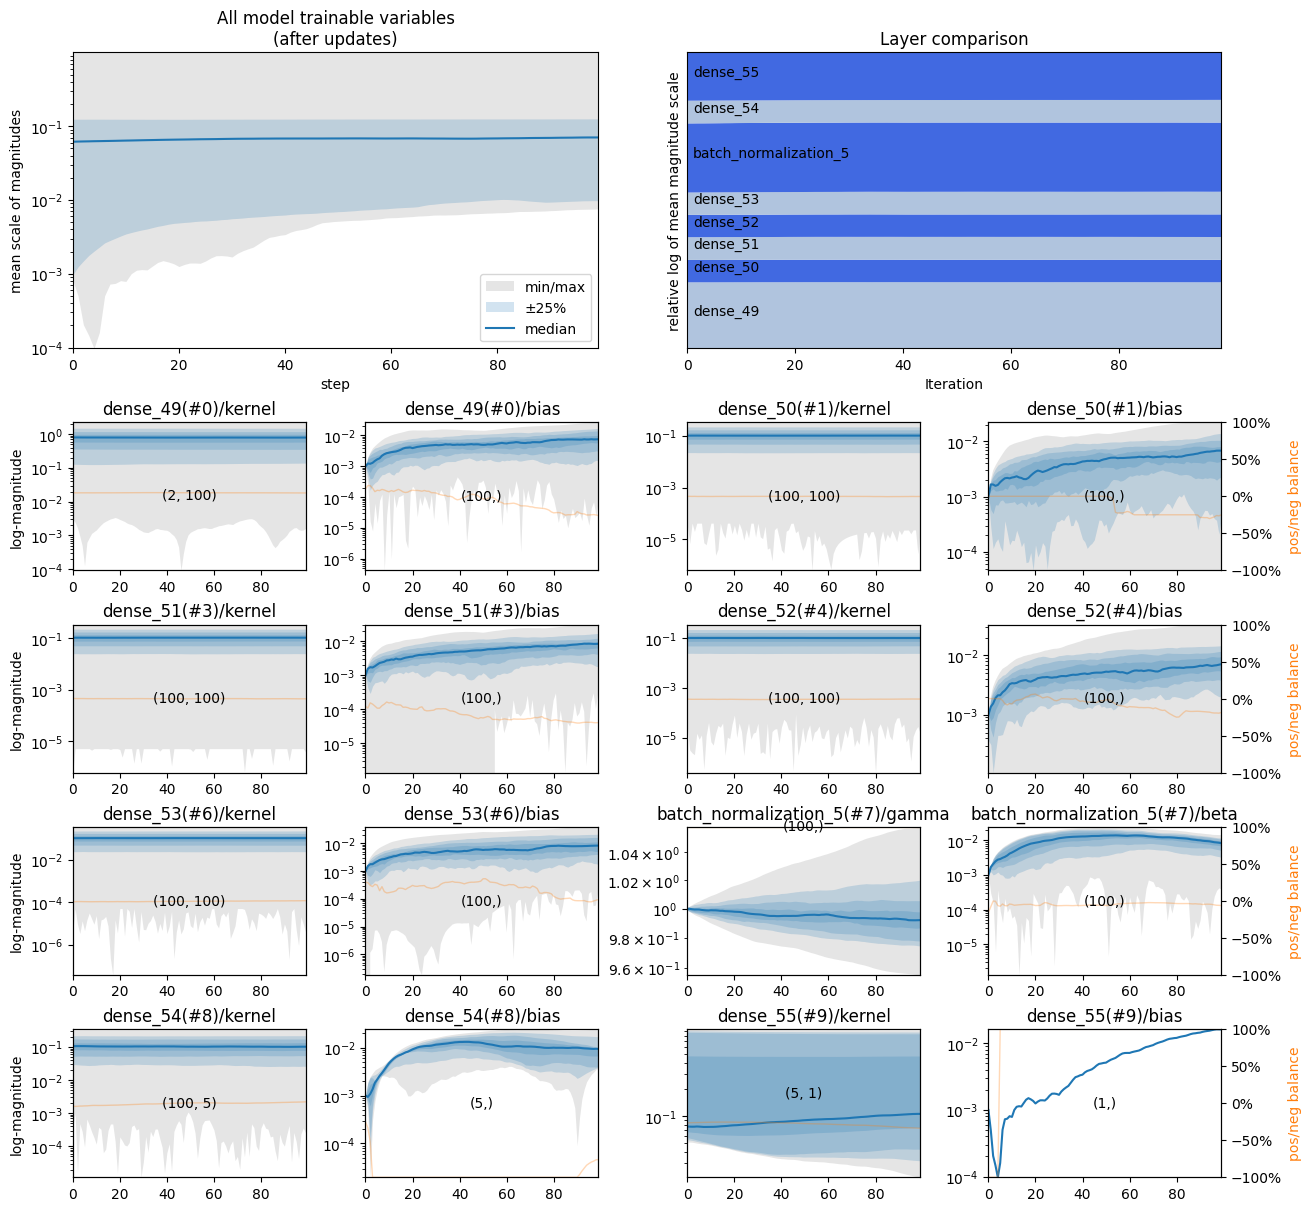

In [76]:
tot.plot_value_history(variables)

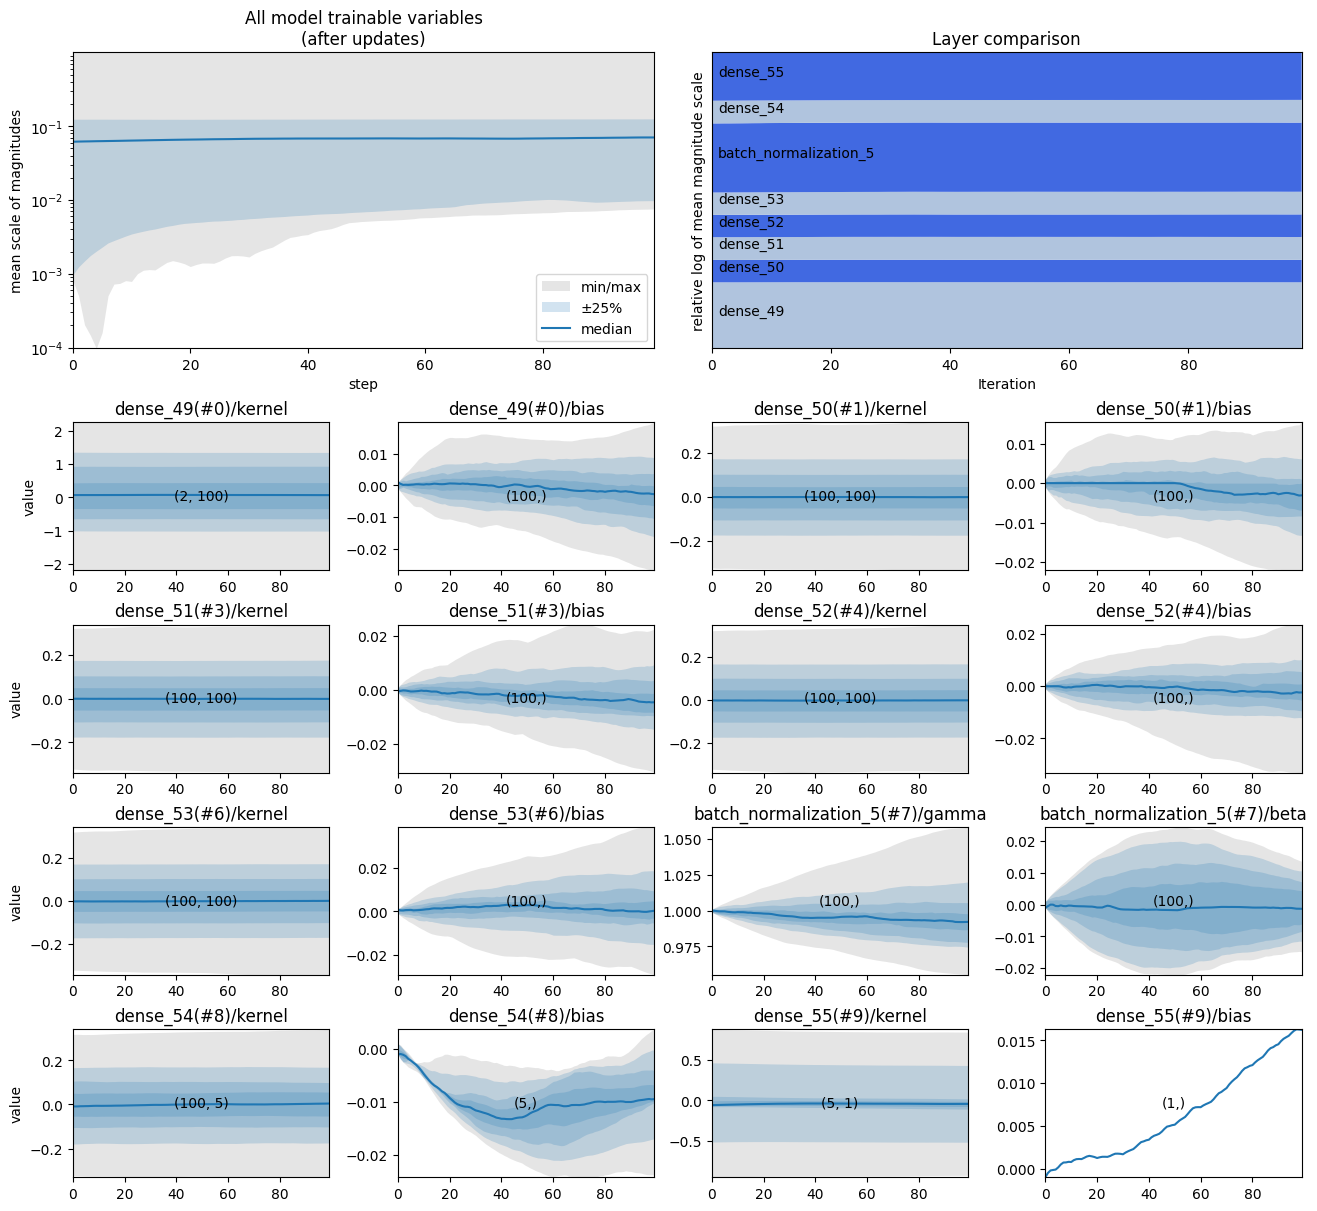

In [77]:
tot.plot_value_history(variables, magnitudes=False)

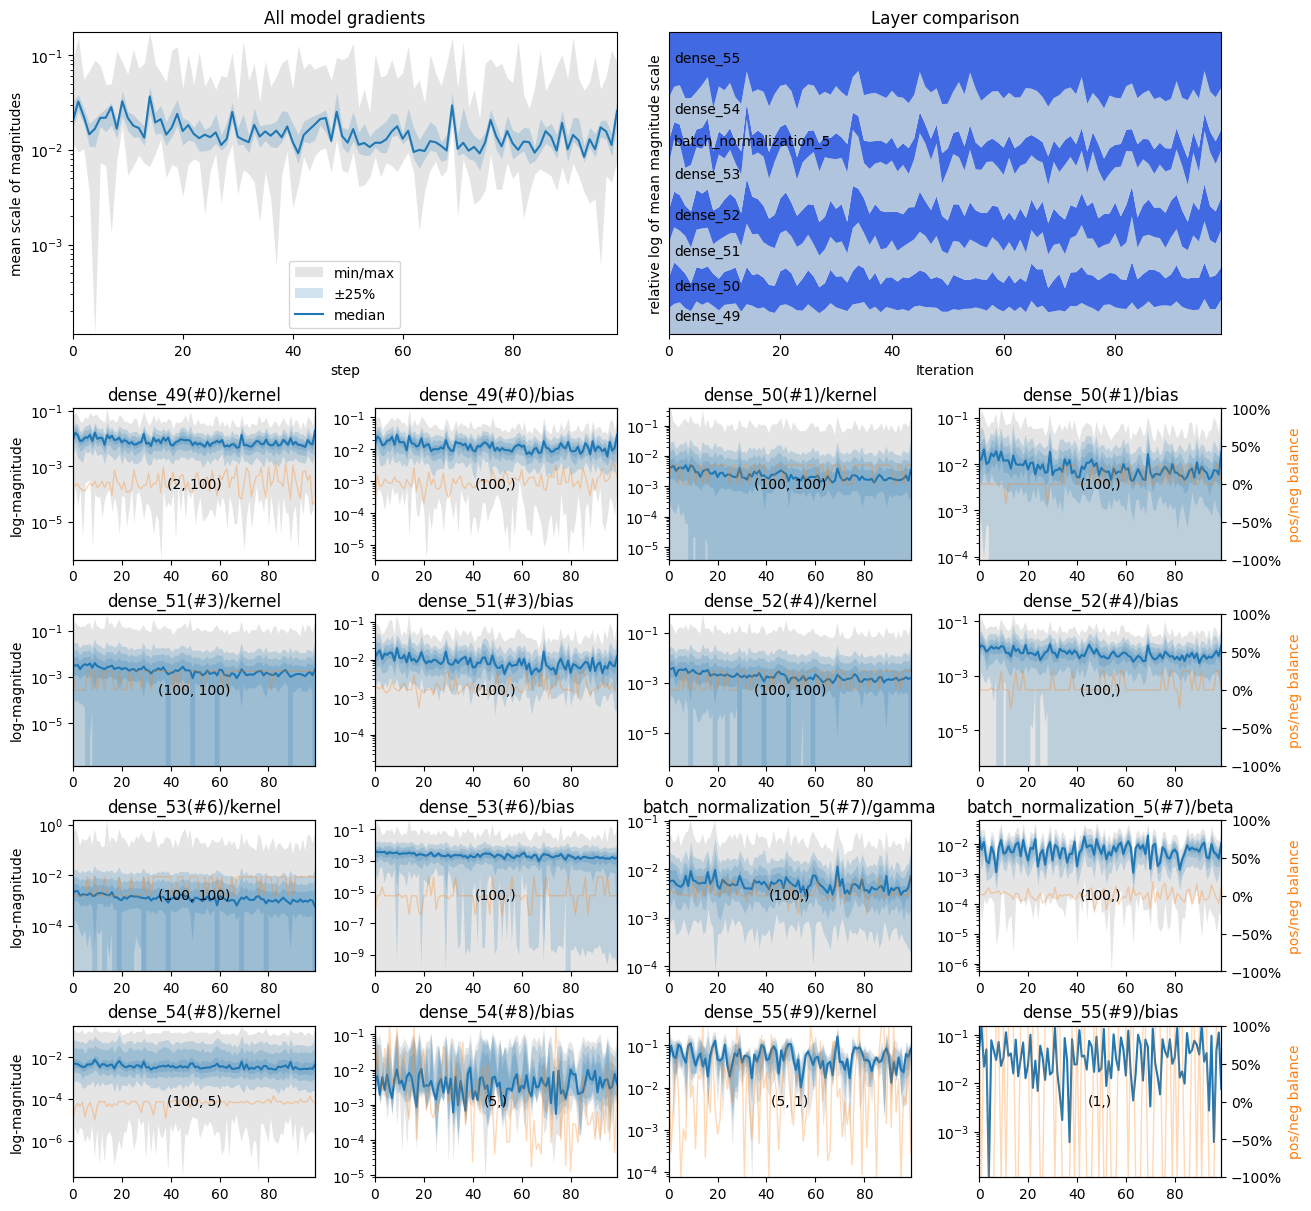

In [78]:
tot.plot_value_history(gradients)

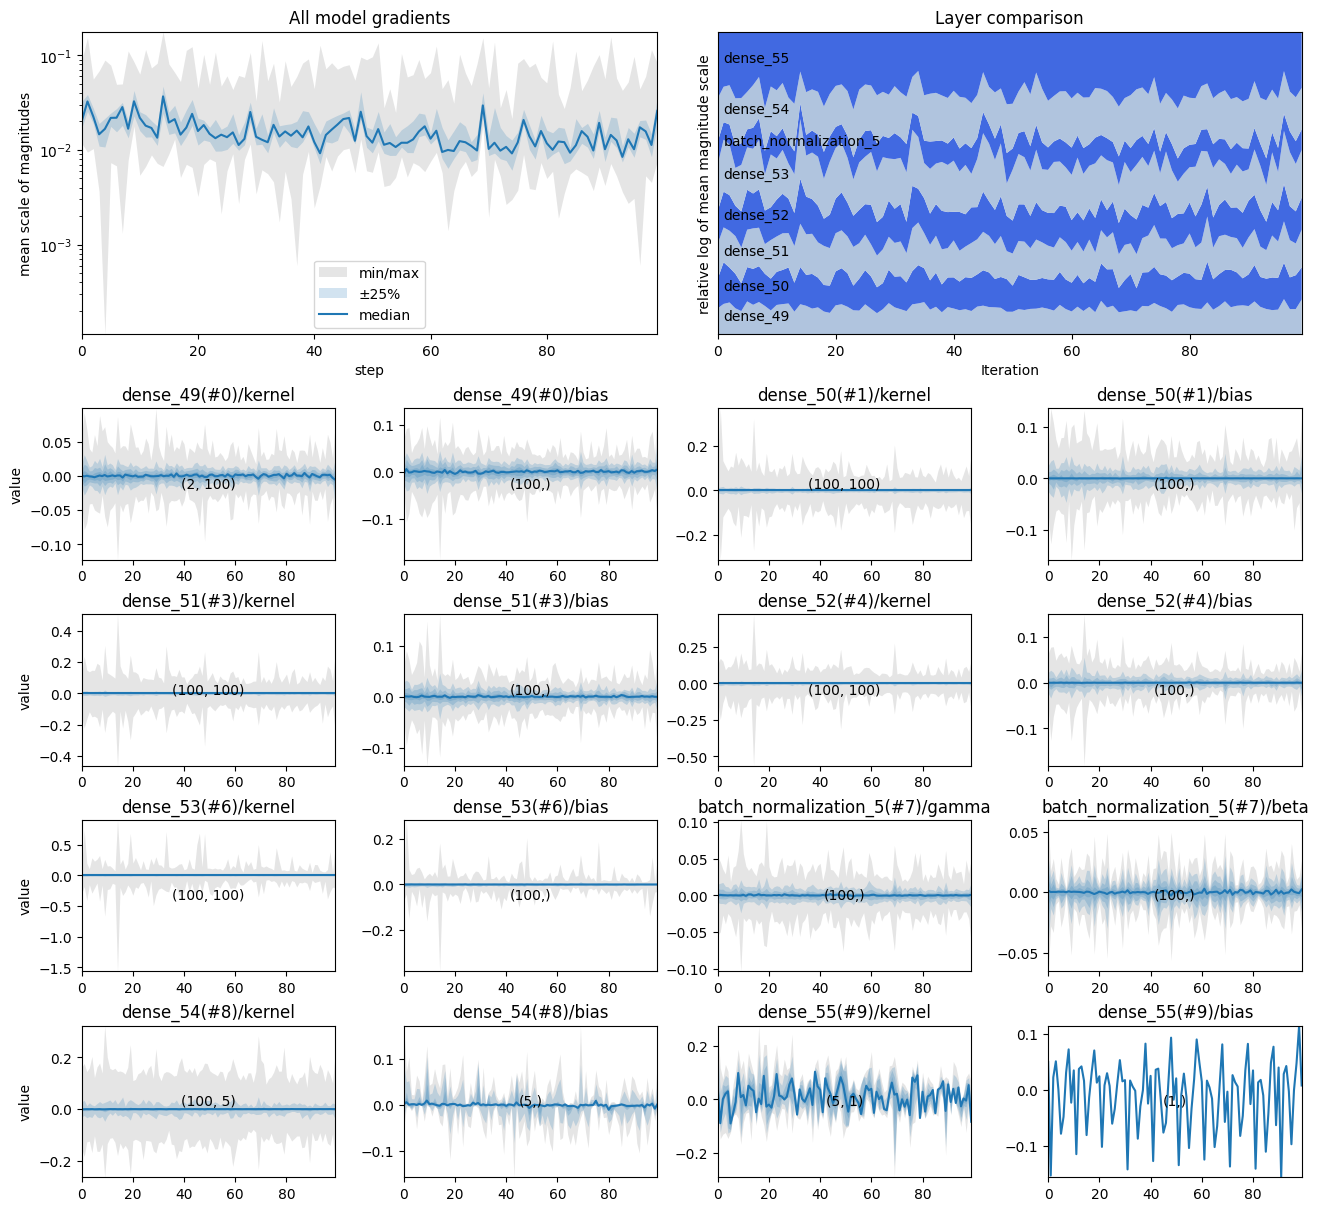

In [79]:
tot.plot_value_history(gradients, magnitudes=False)

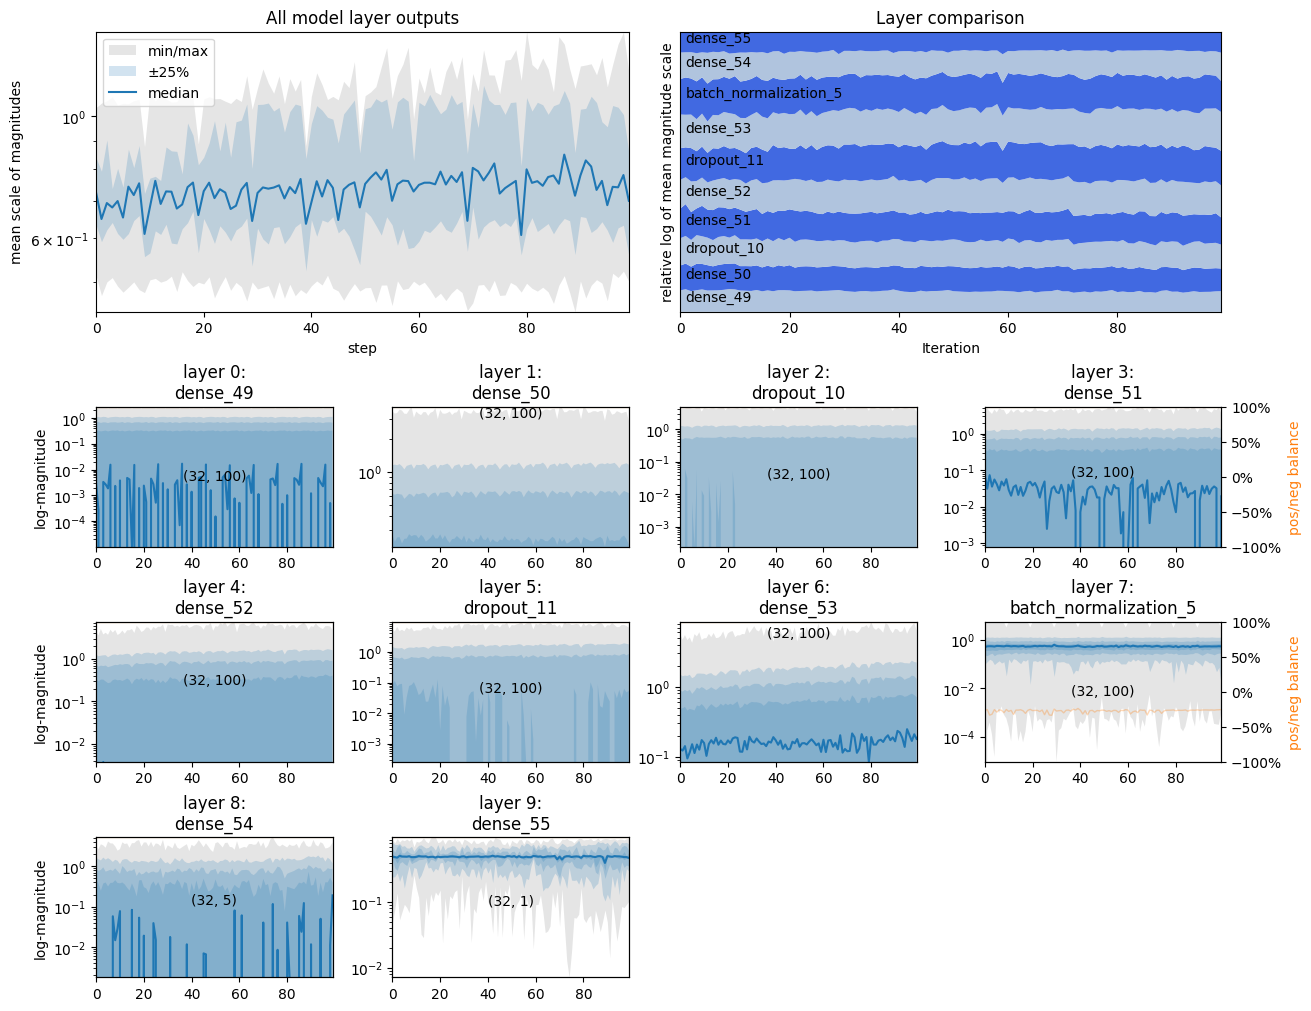

In [80]:
tot.plot_value_history(outputs)

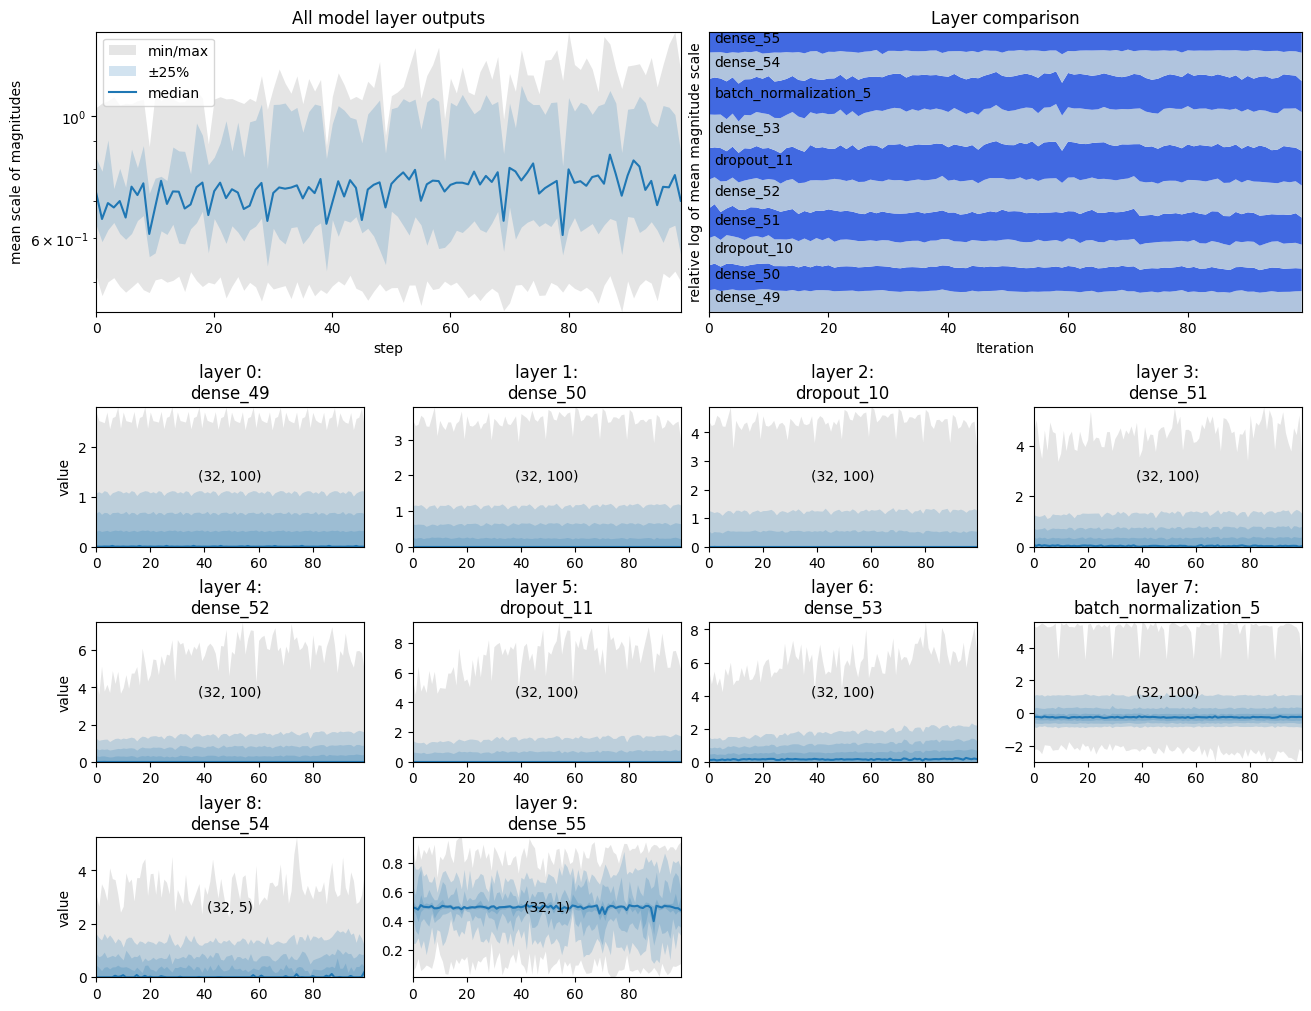

In [81]:
tot.plot_value_history(outputs, magnitudes=False)

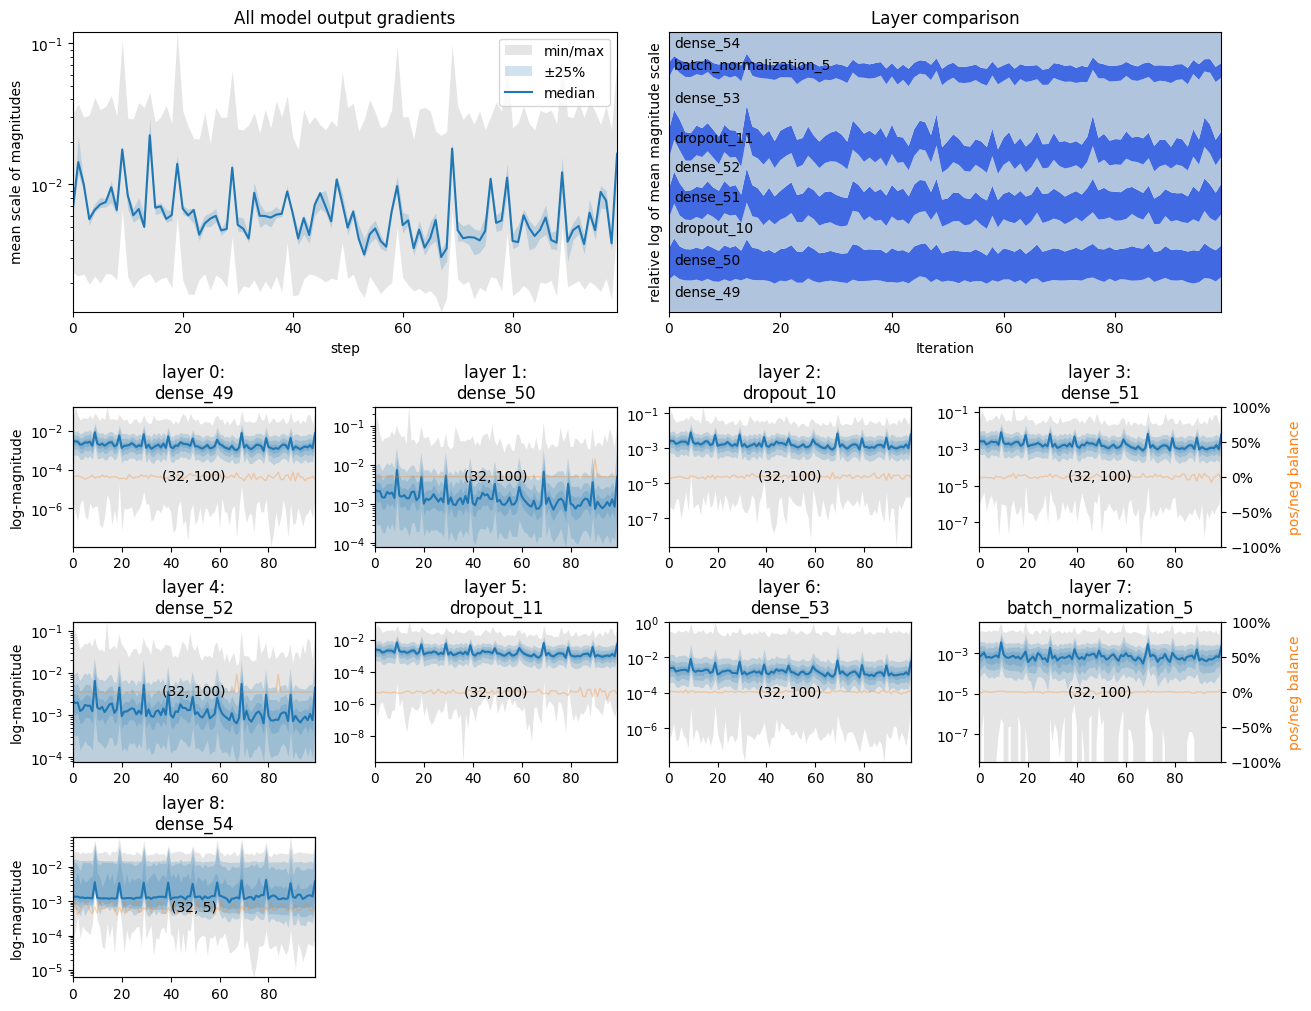

In [82]:
tot.plot_value_history(output_gradients)

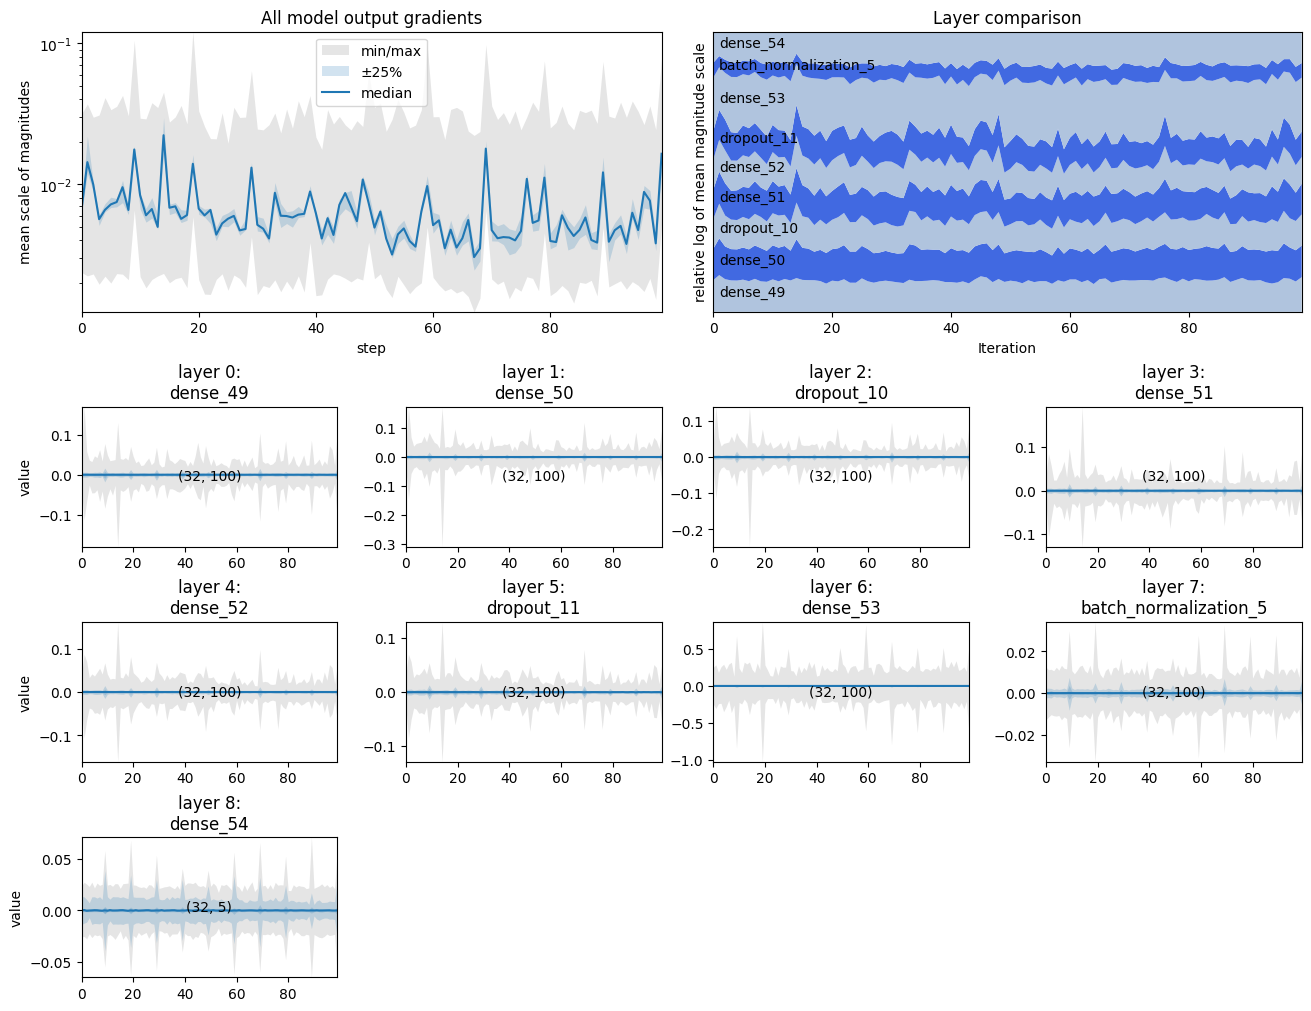

In [83]:
tot.plot_value_history(output_gradients, magnitudes=False)

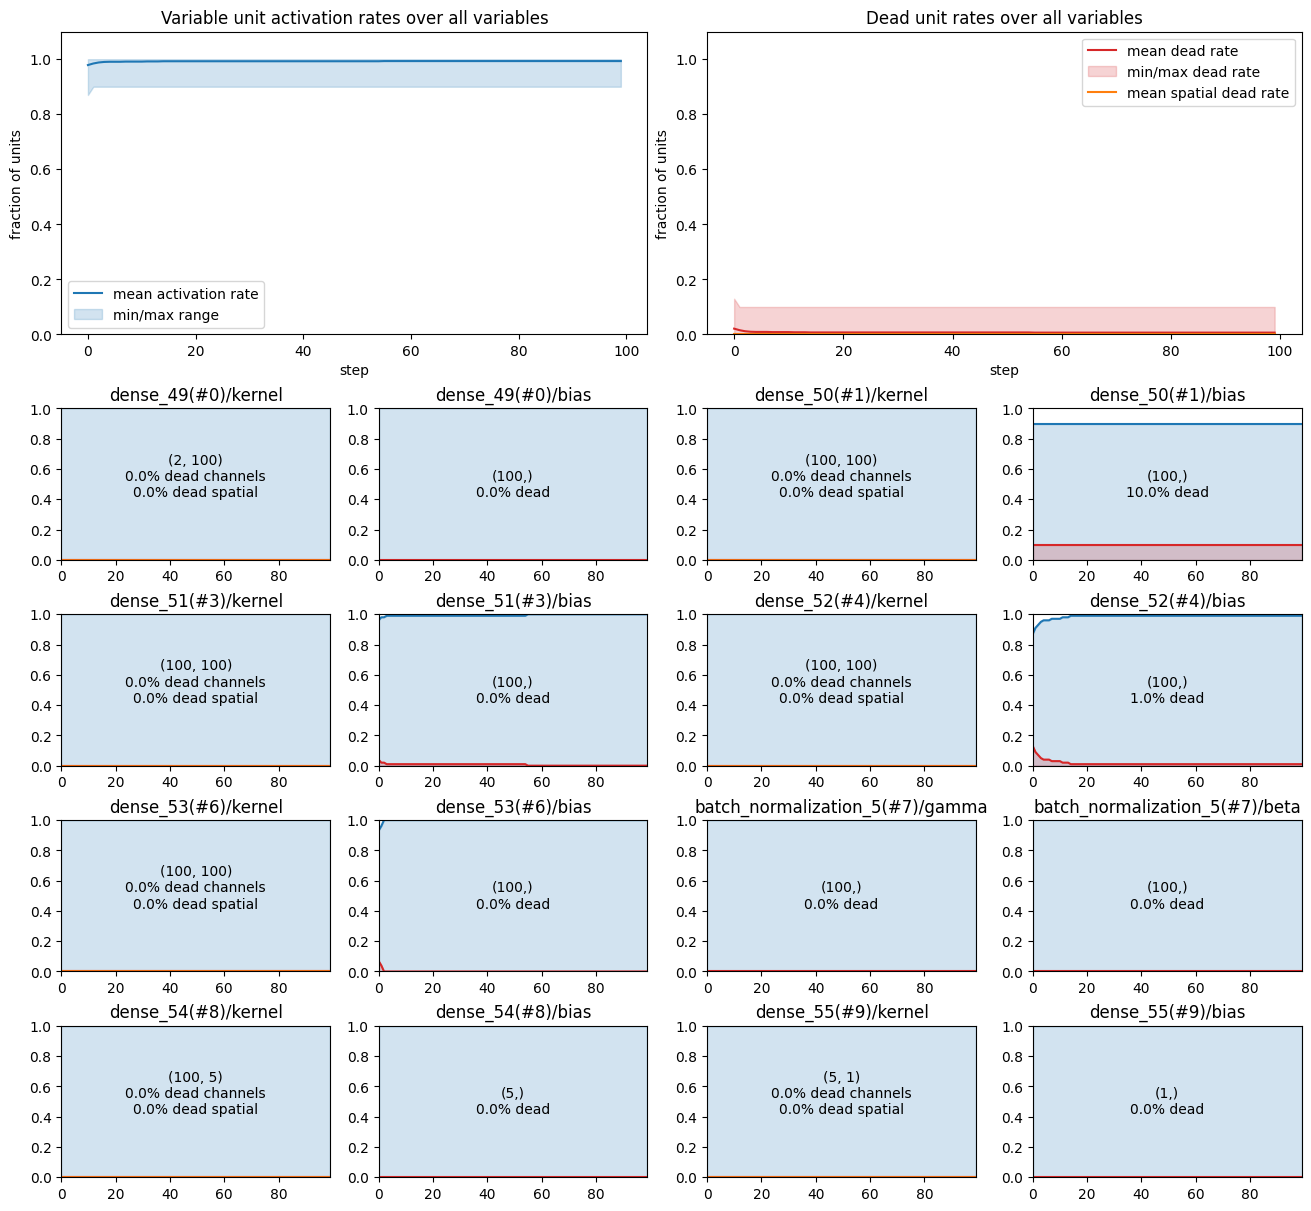

In [84]:
tot.plot_activity_history(variables)

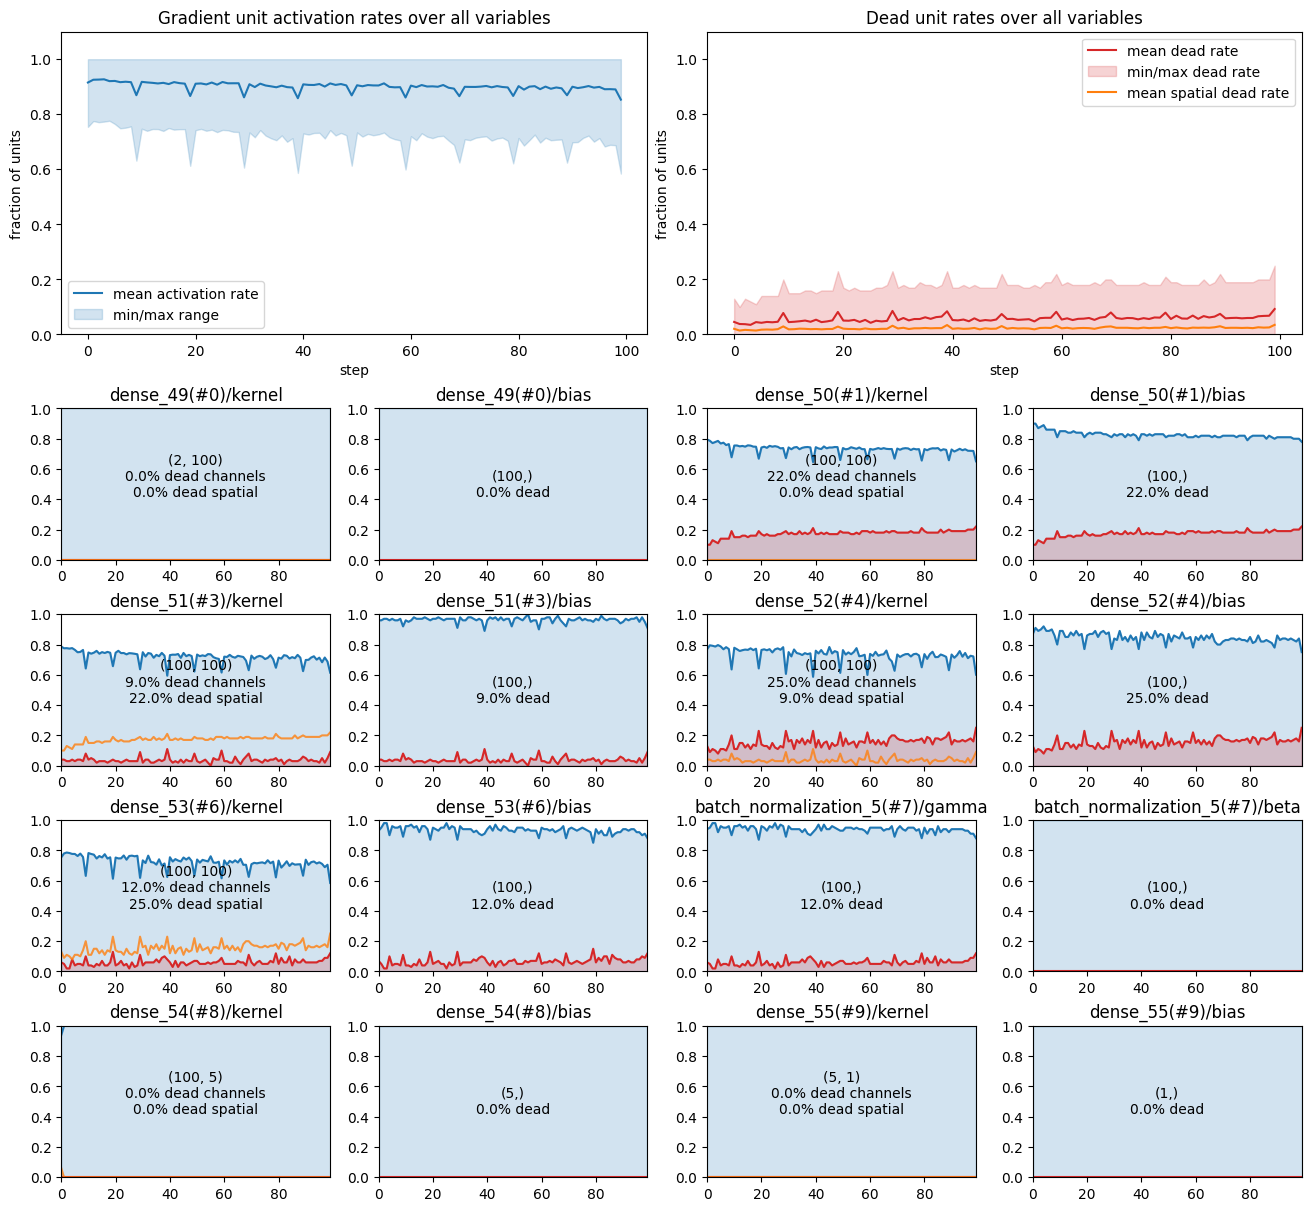

In [85]:
tot.plot_activity_history(gradients)

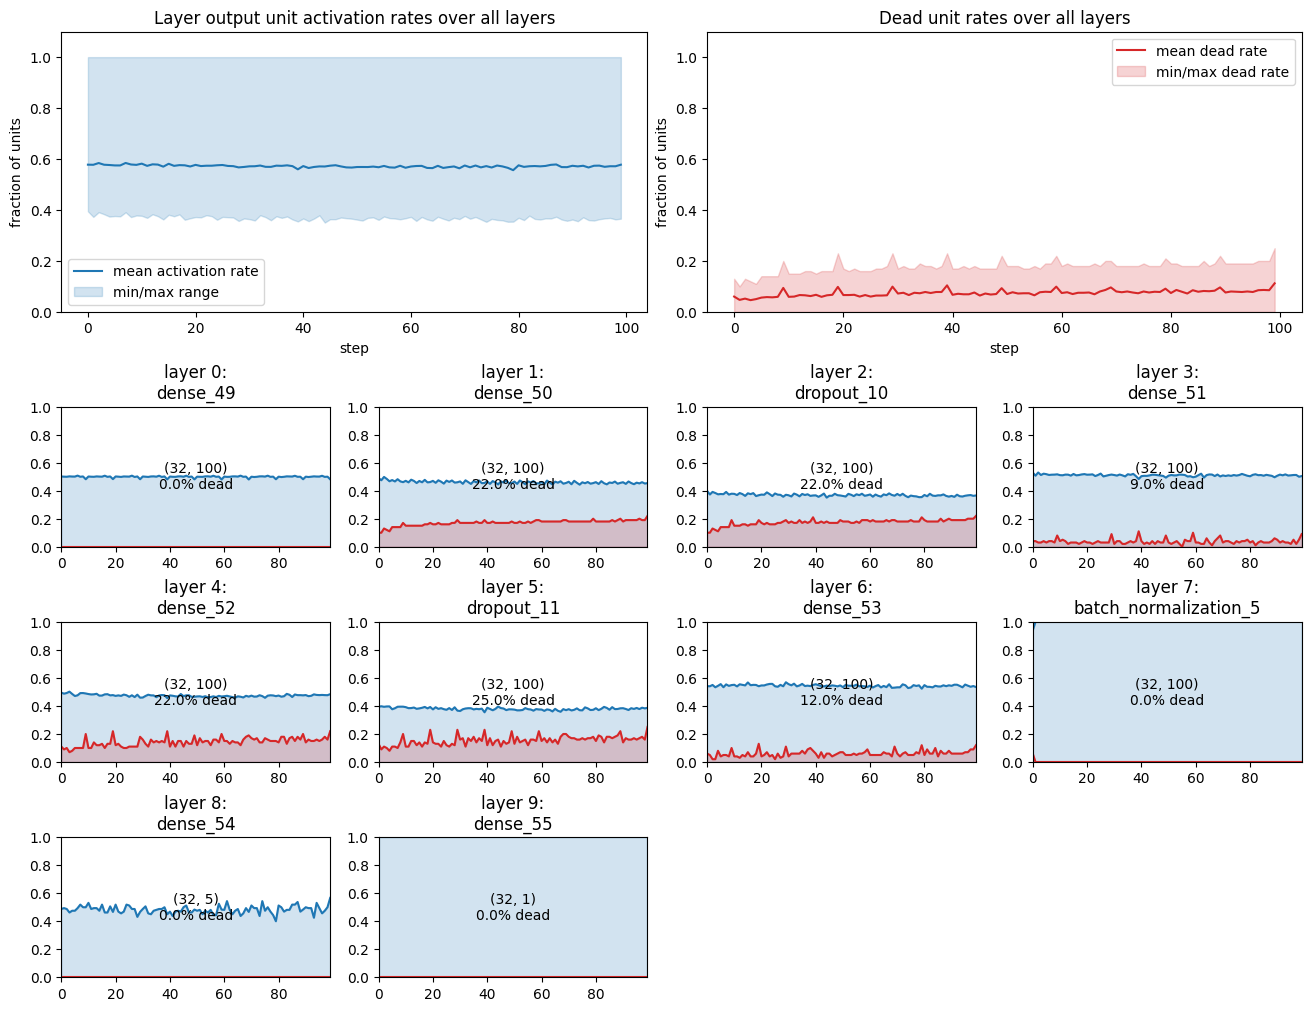

In [86]:
tot.plot_activity_history(outputs)

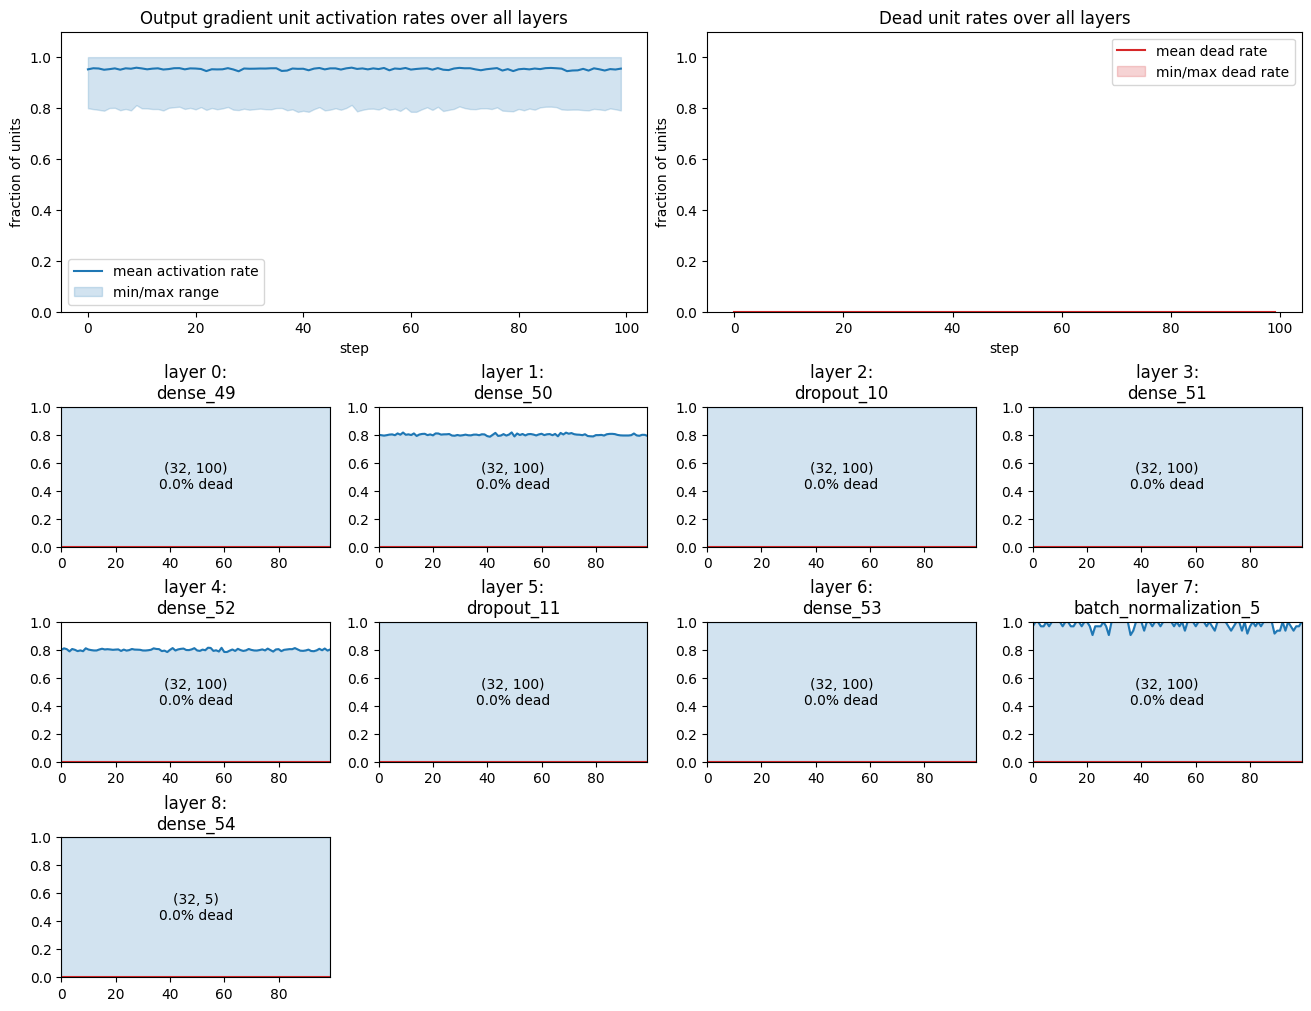

In [87]:
tot.plot_activity_history(output_gradients)

## MNIST CNN

In [23]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


In [32]:
# Model training
reload(tot)
per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)

start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
if per_step:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(1000).batch(64)
  history = tot.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tot.HistoryStats(per_step=per_step)])
else:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
  history = tot.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tot.HistoryStats(per_step=per_step)])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8575 - loss: 0.4816


Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9771 - loss: 0.0797
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9857 - loss: 0.0488
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9901 - loss: 0.0350
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9920 - loss: 0.0262
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9939 - loss: 0.0195
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9945 - loss: 0.0168
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9960 - loss: 0.0118
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9965 - loss: 0.0107
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9962 - loss: 0.0100
Total training time: 93.43 secs


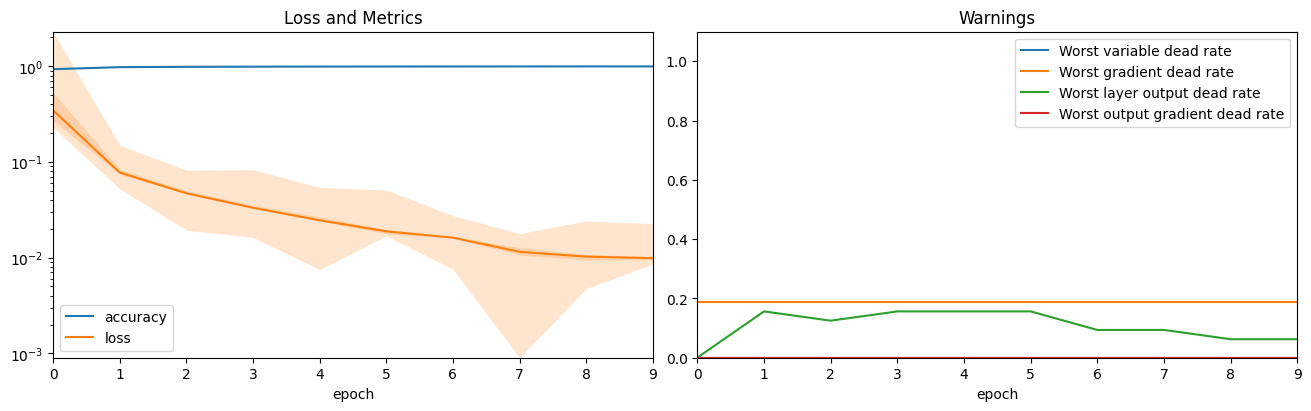

In [64]:
tot.plot_history_overview([history, variables, gradients, outputs, output_gradients], details=False)

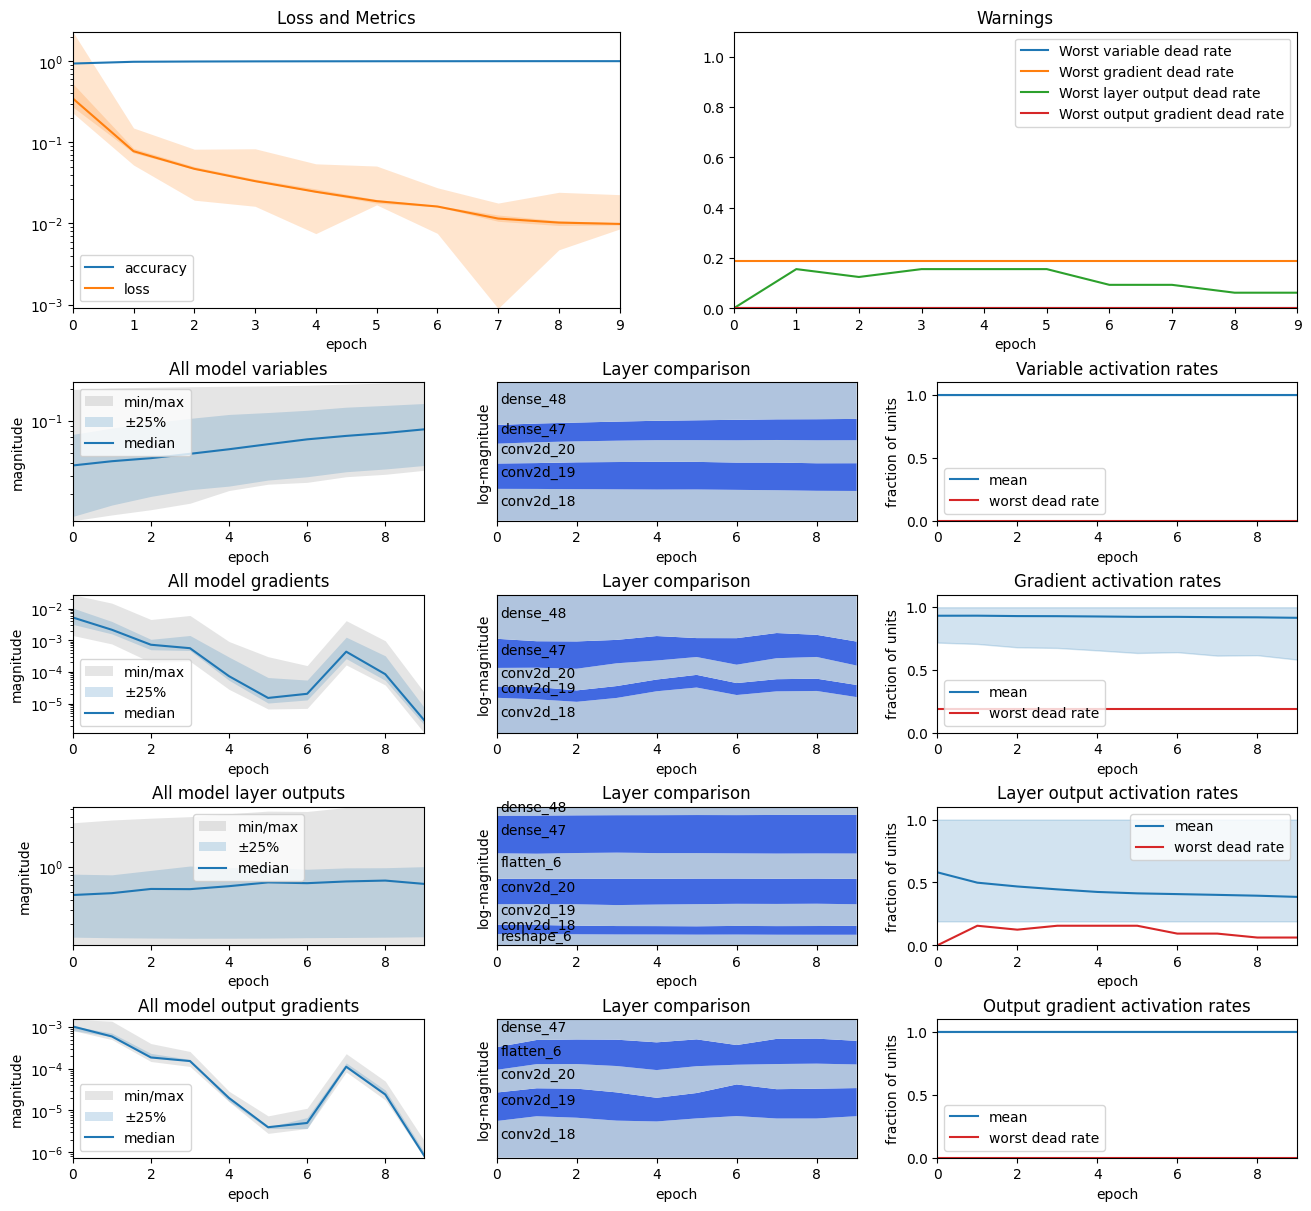

In [65]:
tot.plot_history_overview([history, variables, gradients, outputs, output_gradients])

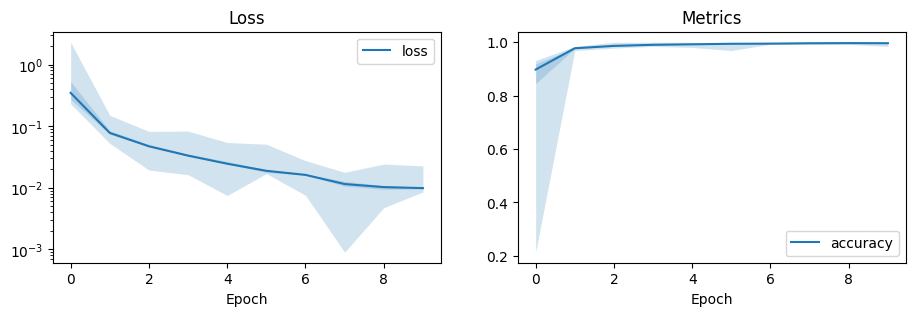

In [34]:
tot.plot_train_history(history)

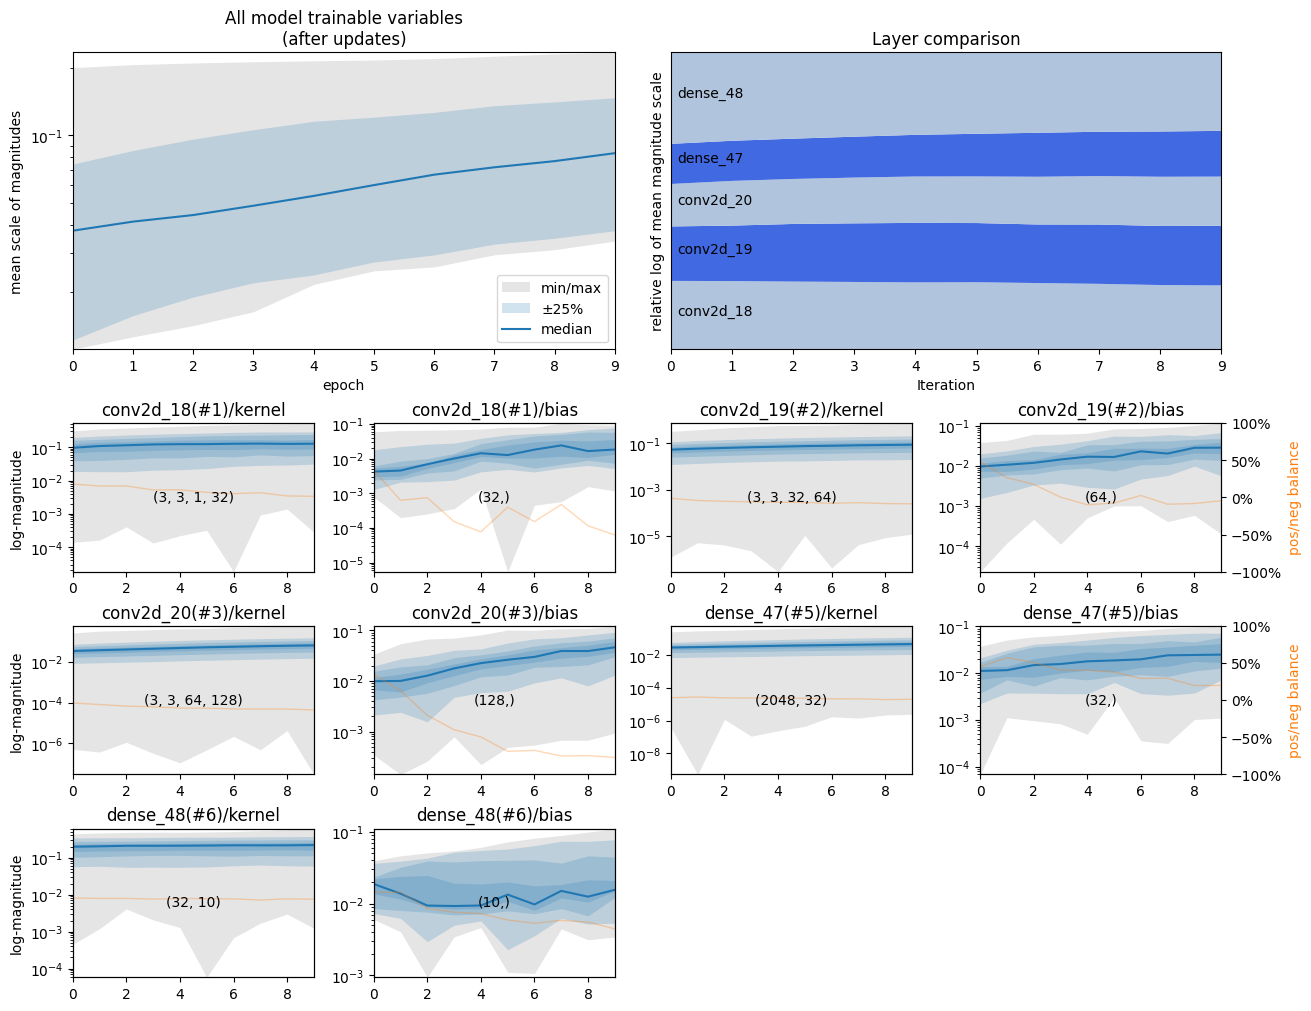

In [36]:
tot.plot_value_history(variables)

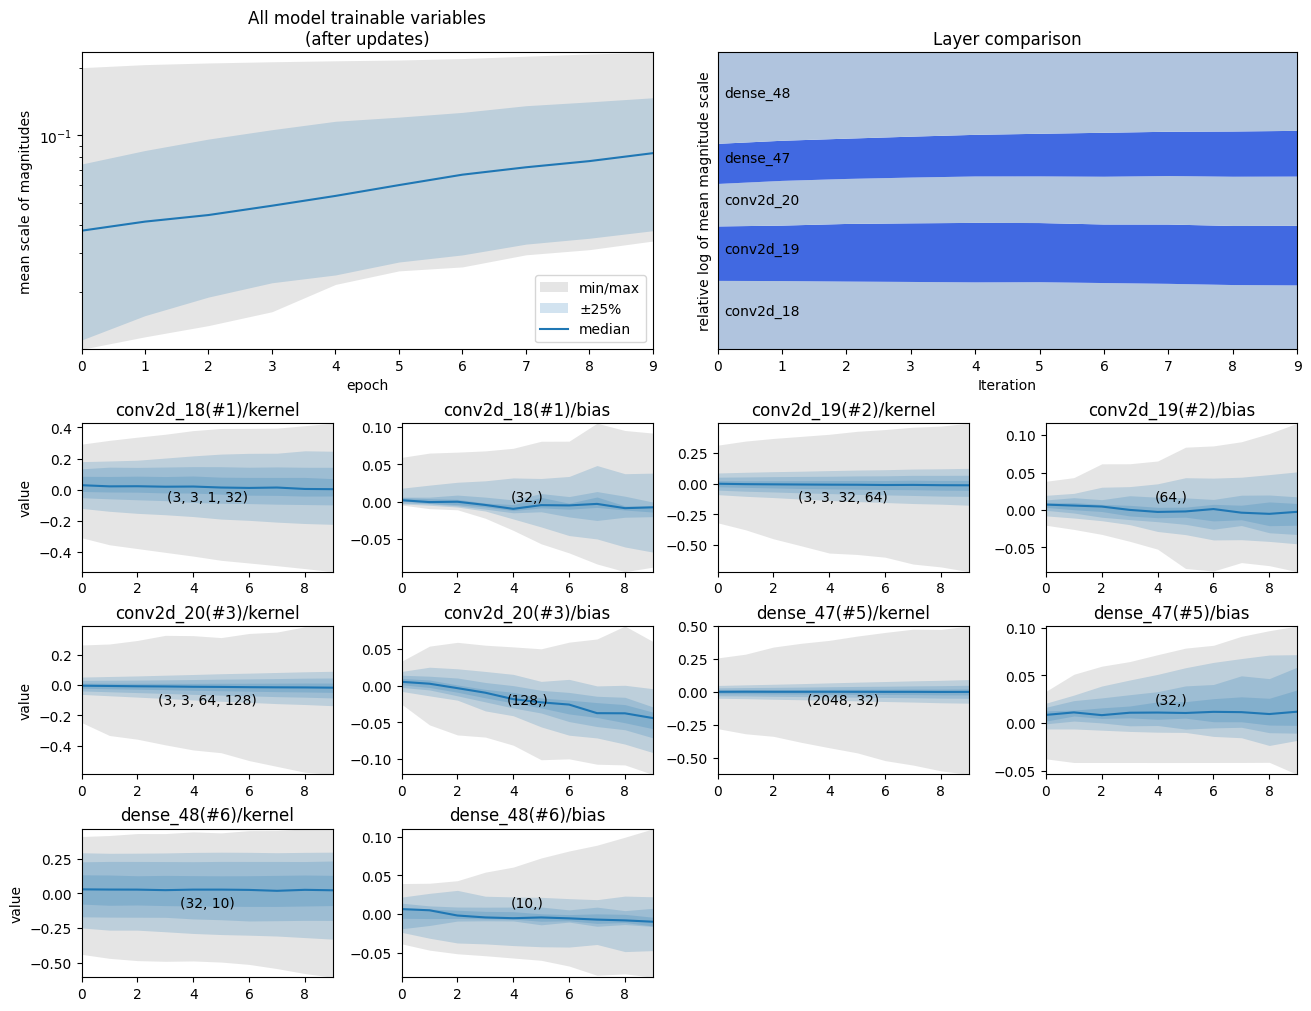

In [37]:
tot.plot_value_history(variables, magnitudes=False)

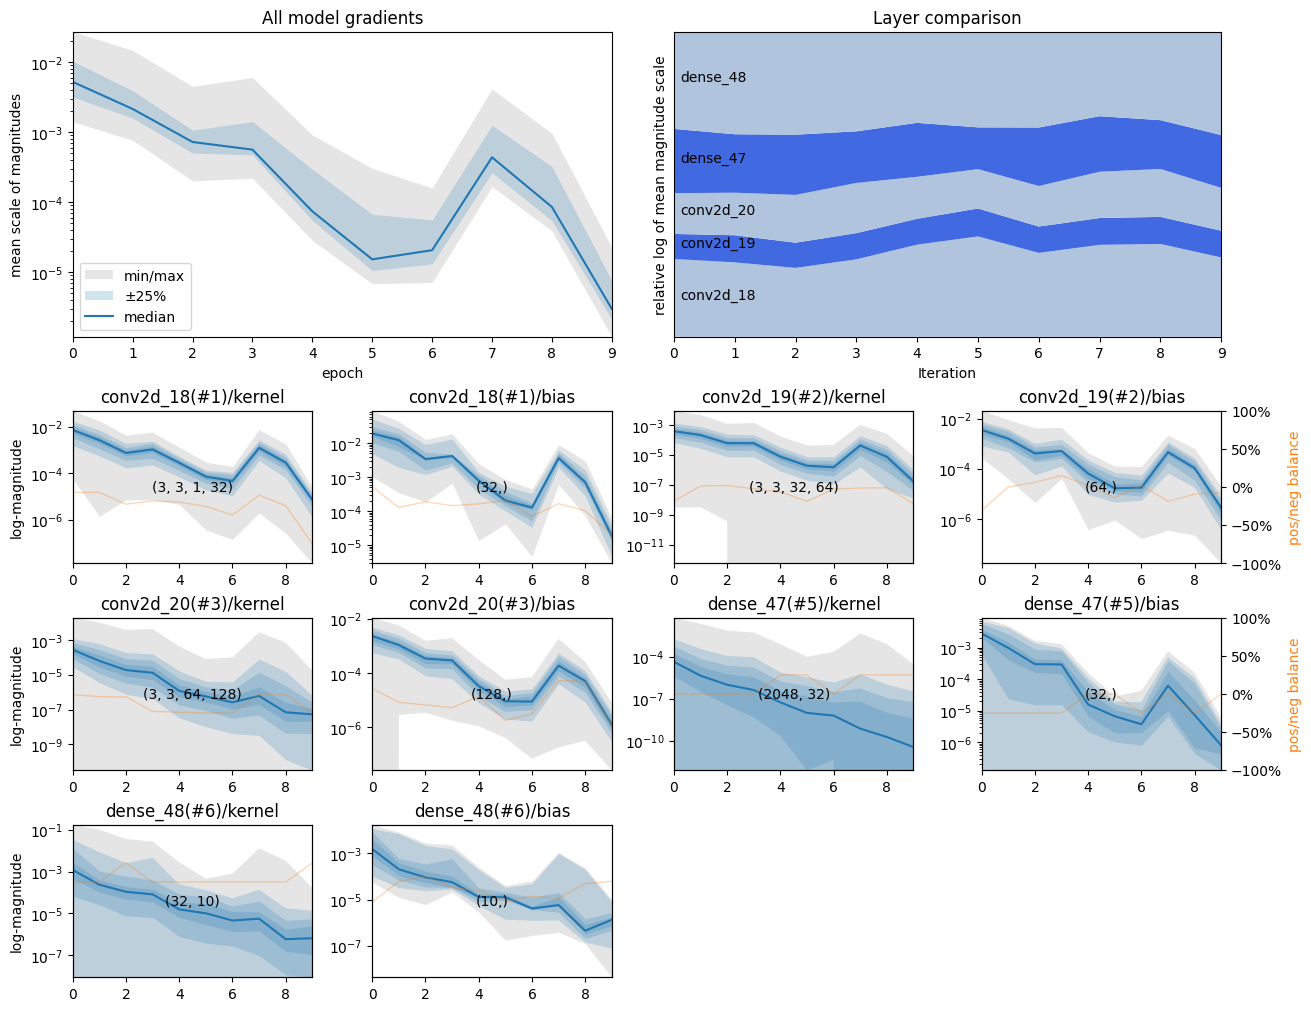

In [38]:
tot.plot_value_history(gradients)

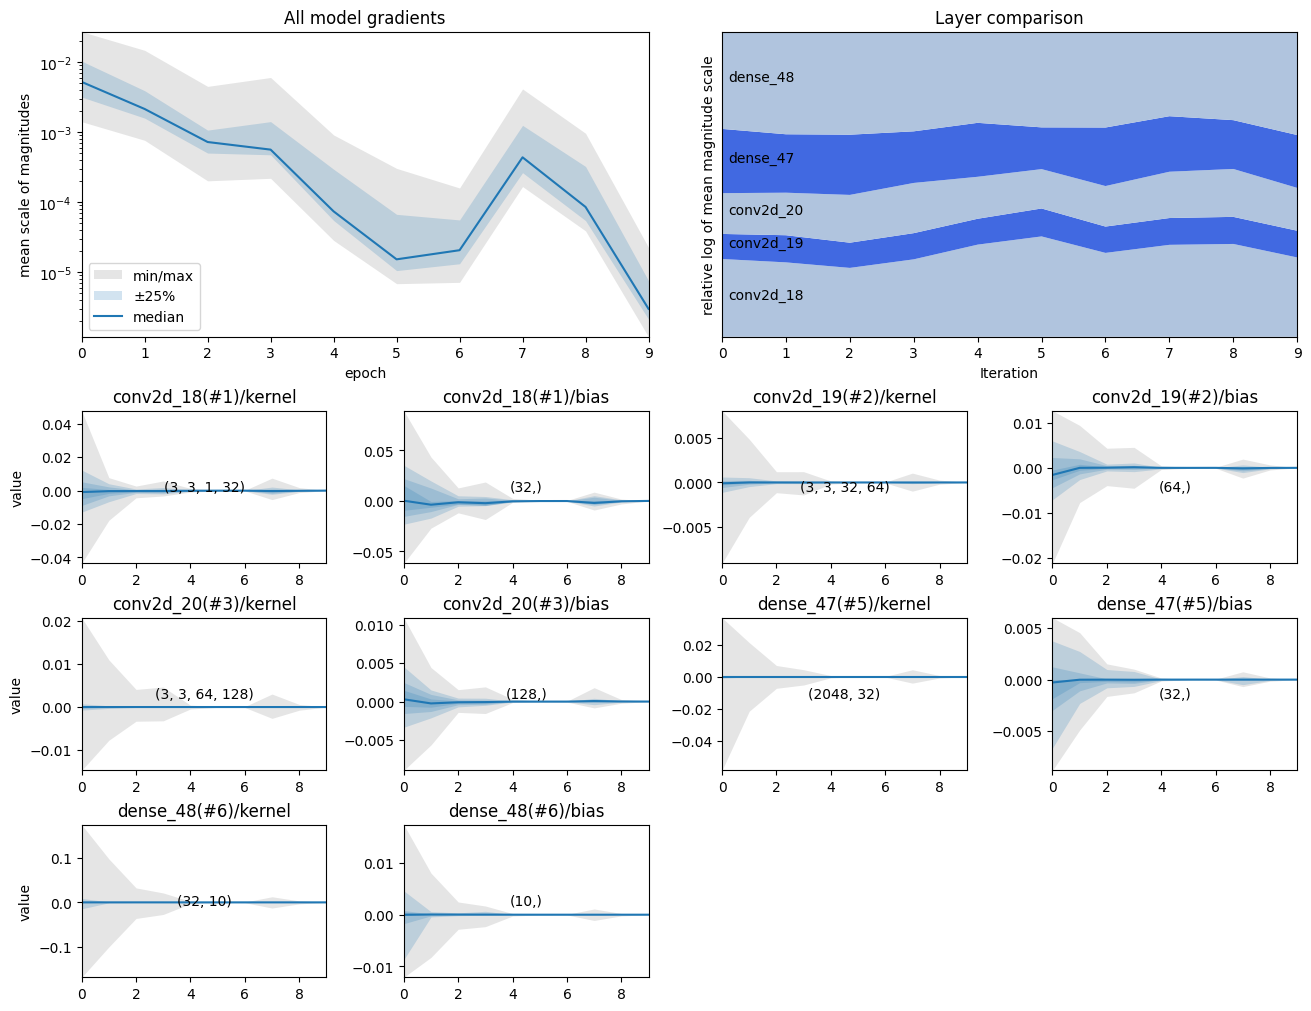

In [39]:
tot.plot_value_history(gradients, magnitudes=False)

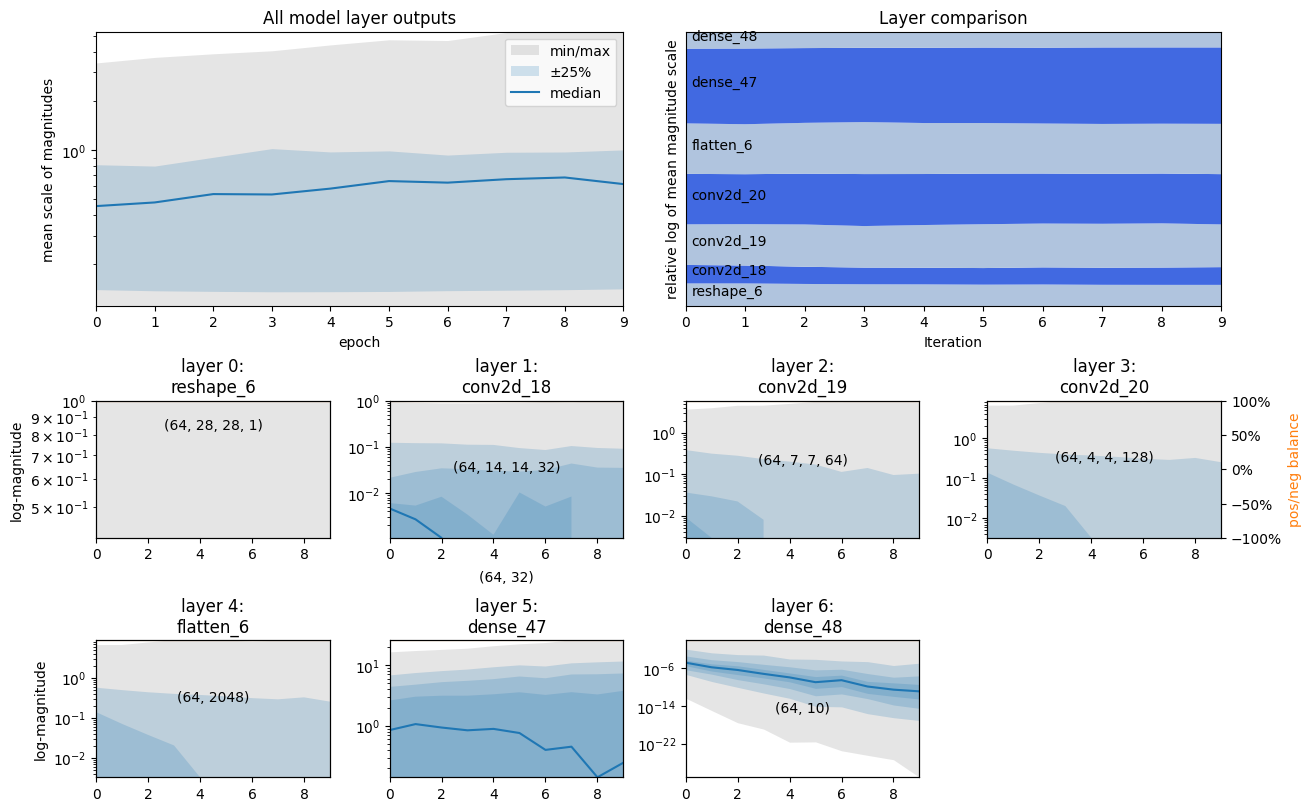

In [40]:
tot.plot_value_history(outputs)

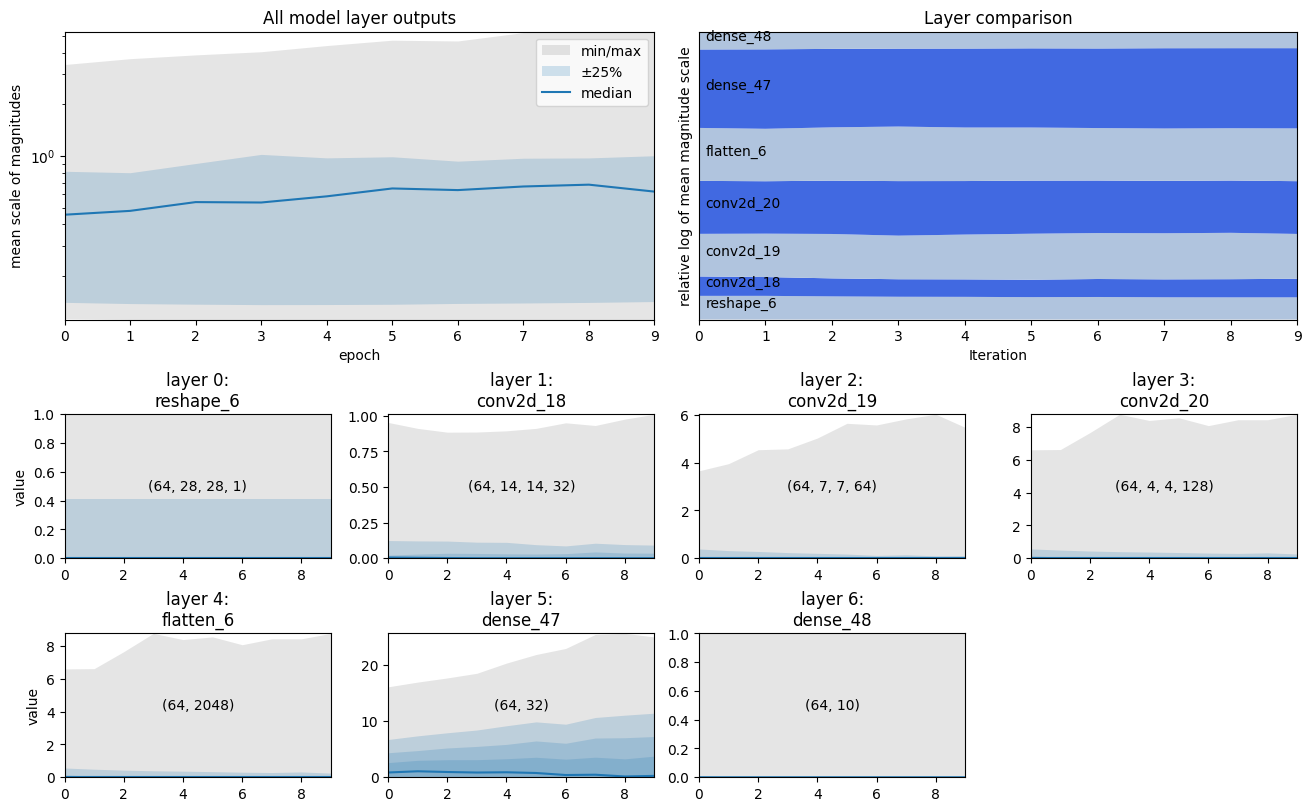

In [41]:
tot.plot_value_history(outputs, magnitudes=False)

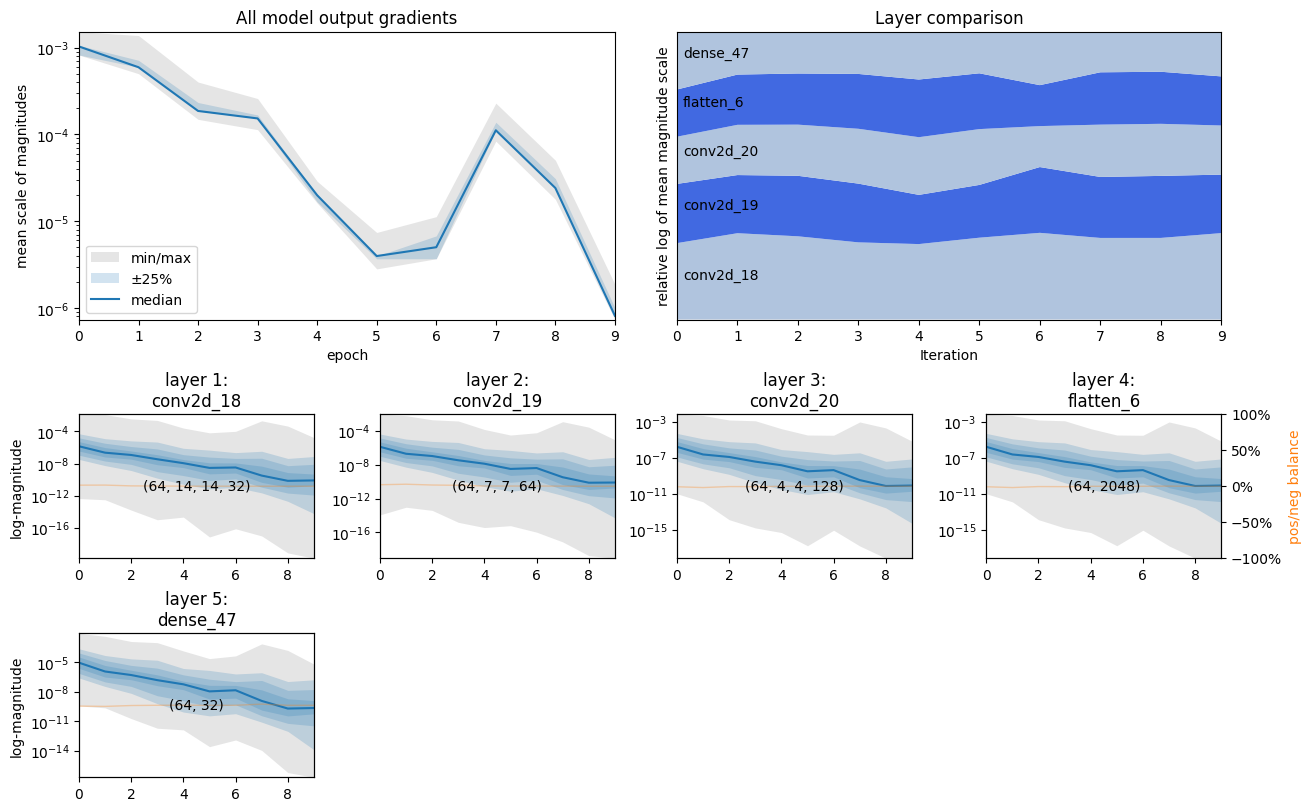

In [42]:
tot.plot_value_history(output_gradients)

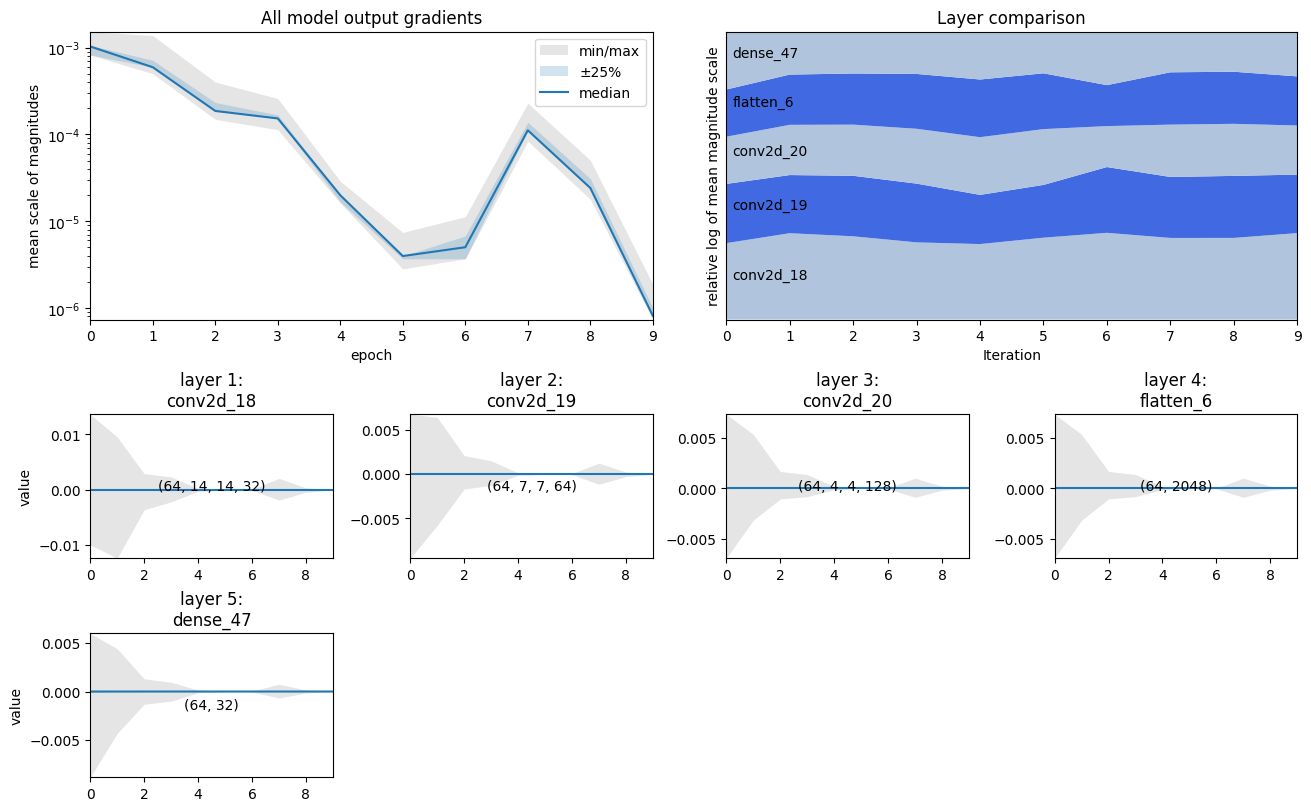

In [43]:
tot.plot_value_history(output_gradients, magnitudes=False)

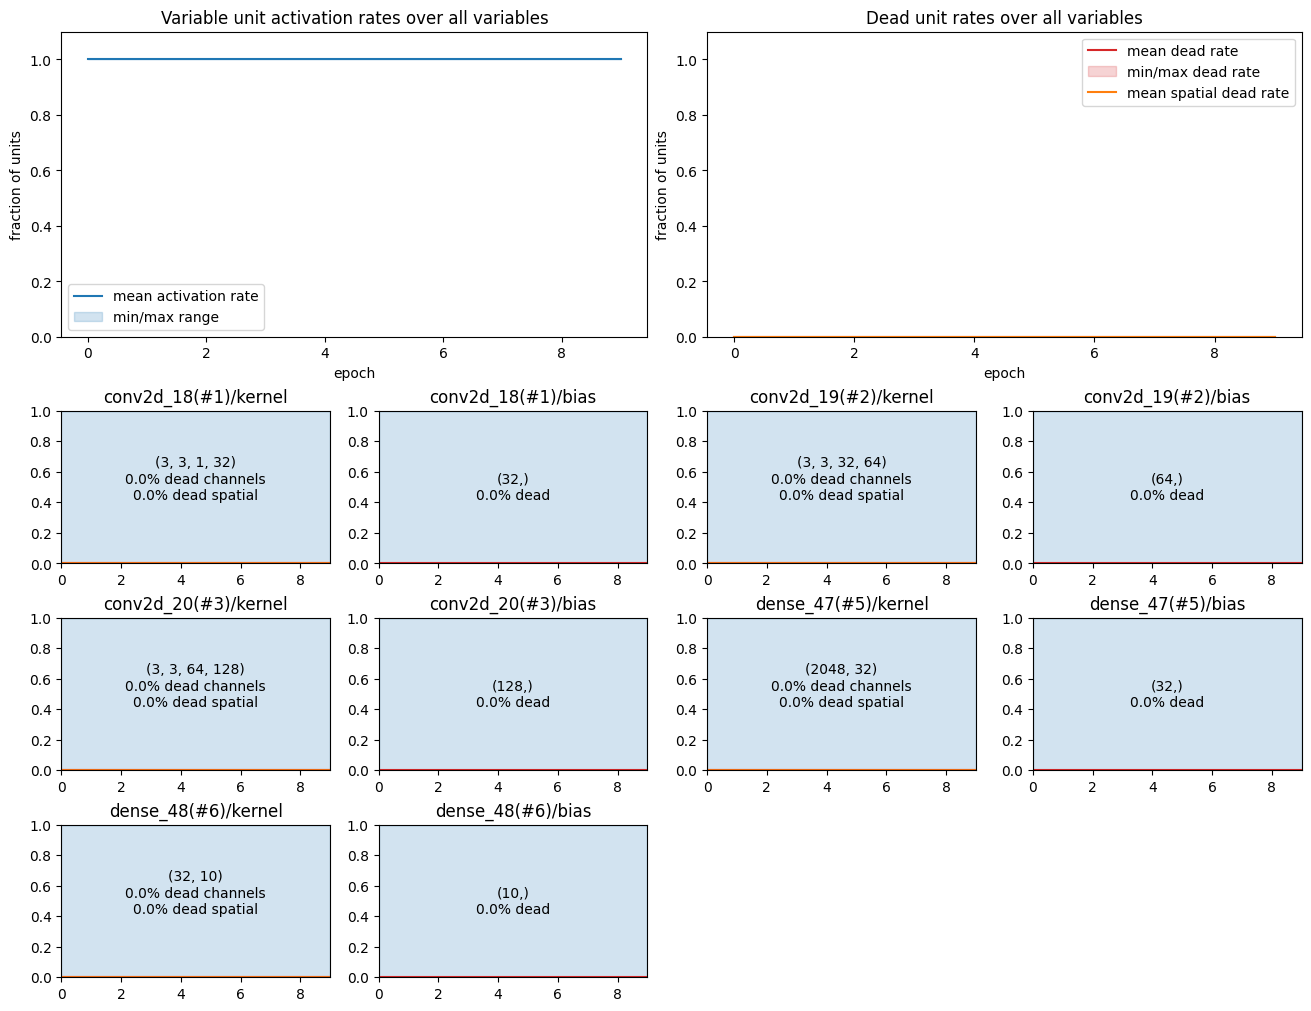

In [58]:
tot.plot_activity_history(variables)

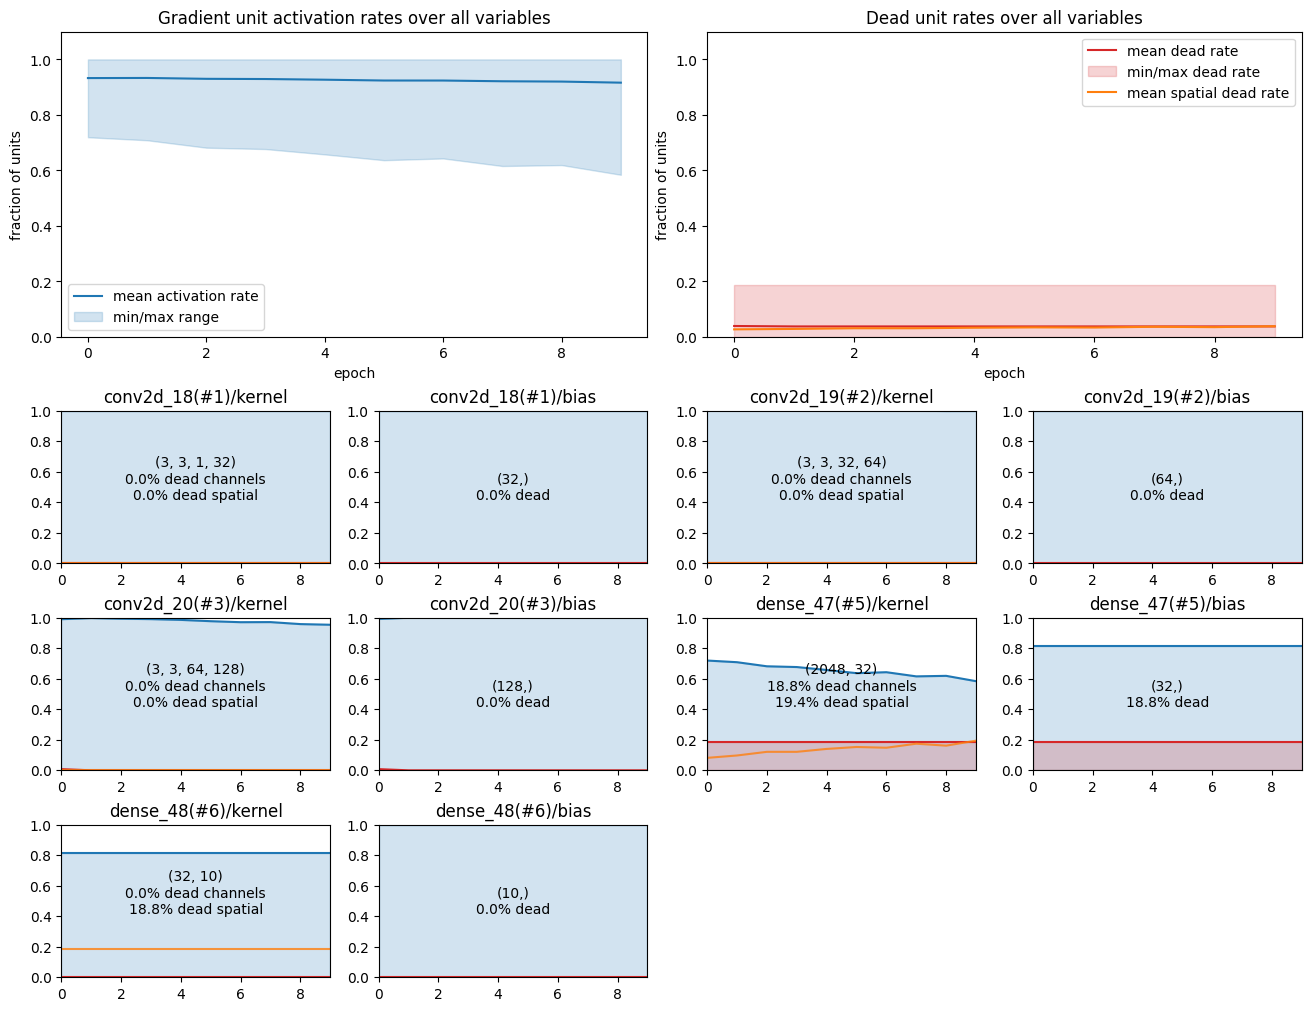

In [55]:
reload(tot)
tot.plot_activity_history(gradients)

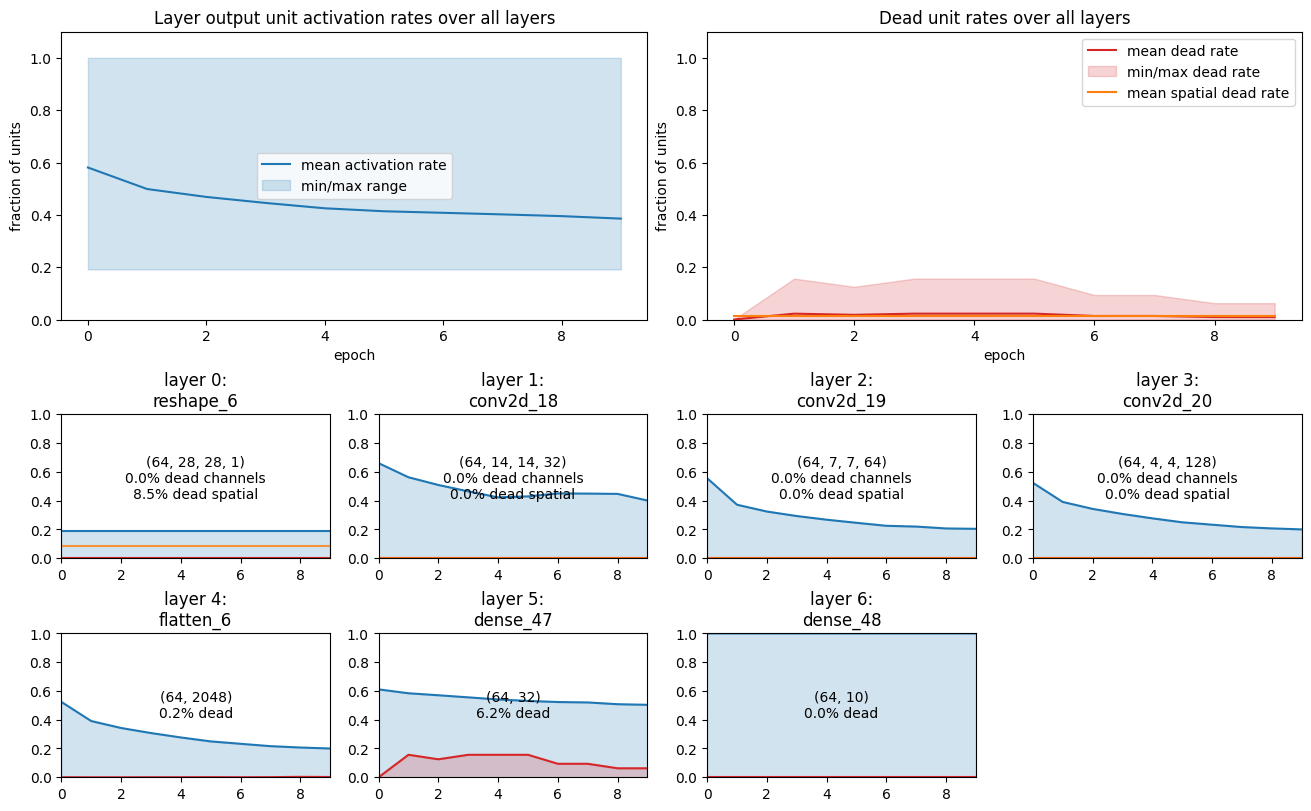

In [56]:
tot.plot_activity_history(outputs)

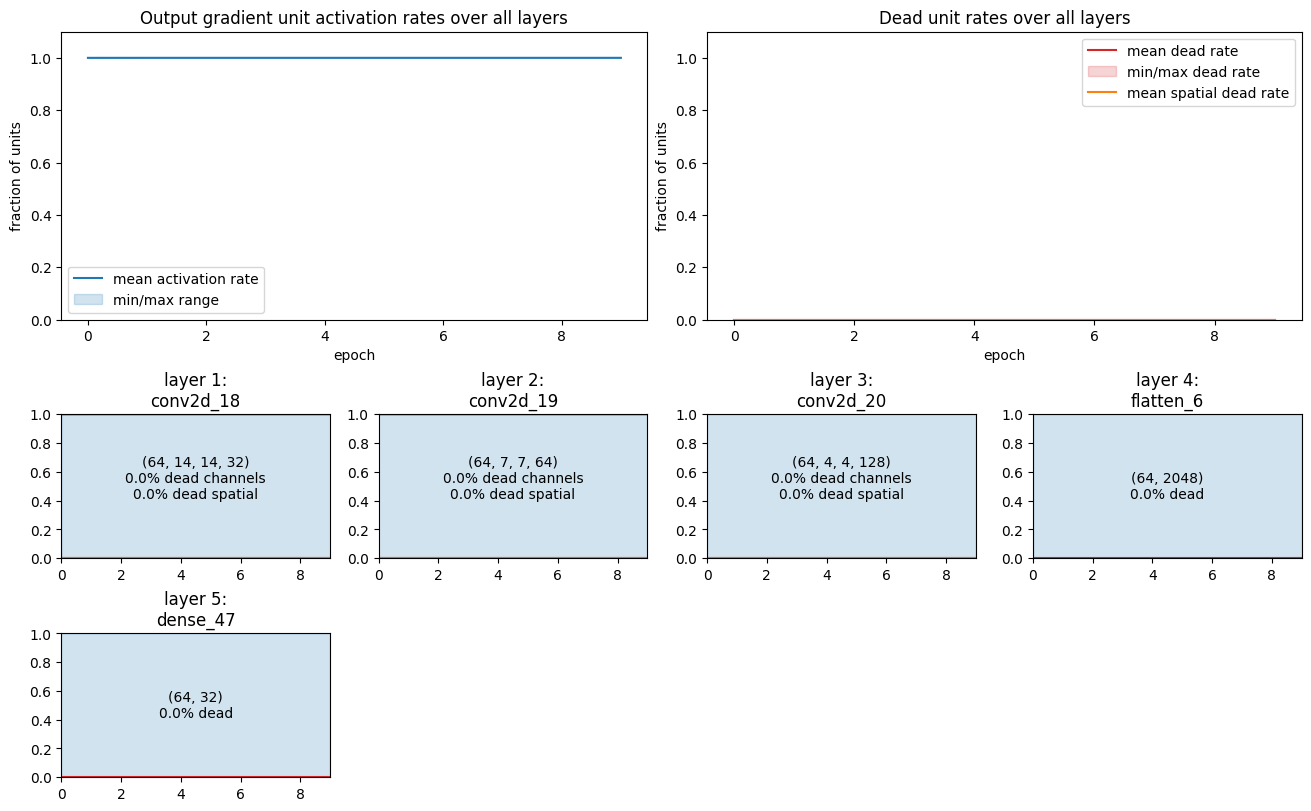

In [57]:
tot.plot_activity_history(output_gradients)

## Spatial unit activity
I've made no changes here, but just confirming that it still works.

In [67]:
reload(tot)
model_stats, layer_stats, layer_channel_activity, layer_spatial_activity = tot.measure_unit_activity(model, dataset, include_channel_activity=True, include_spatial_activity=True)

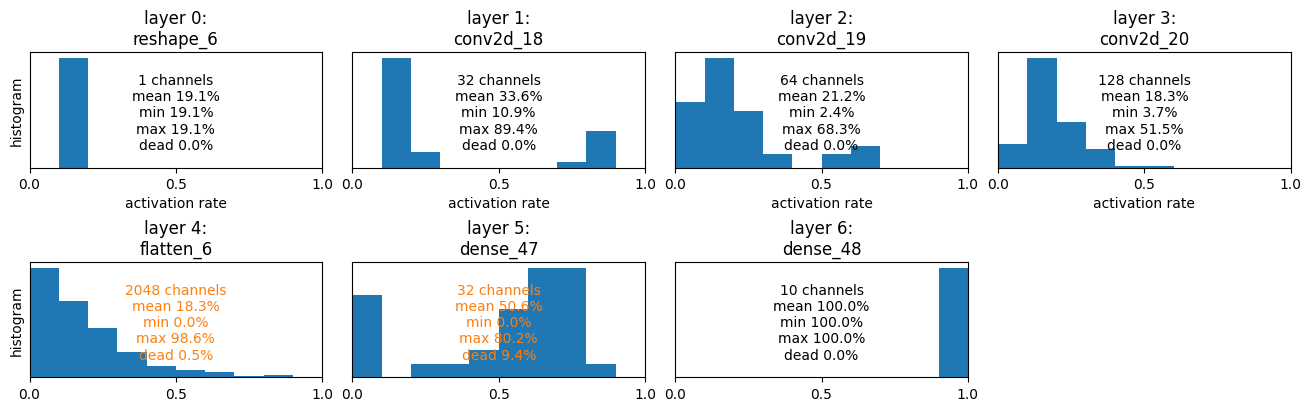

In [69]:
tot.plot_channel_stats(layer_channel_activity, model)

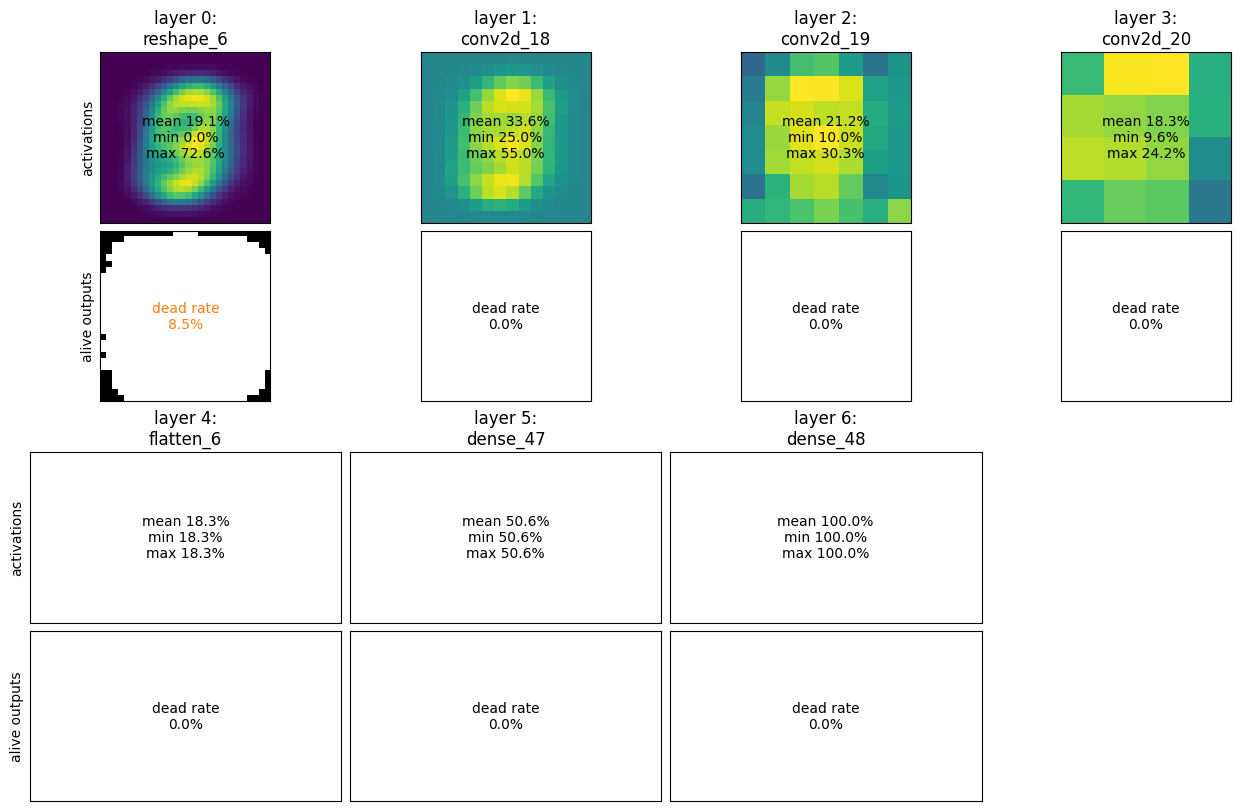

In [70]:
tot.plot_spatial_stats(layer_spatial_activity, model)